# Data Collection
Bagian ini berisi cara pengumpulan data satu per satu dan metode denoising yang digunakan

Pengambilan data dari google drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

In [ ]:
import numpy as np
import h5py

In [ ]:
with h5py.File('/content/drive/MyDrive/PKM_KC_EEG_2021/Hasil_Feature_Visualisasi_mean.csv') as hf:
  ls = list(hf.keys())
  print(ls)
  # data = hf.get(ls[0])
  # data = np.array(data)
  # print(data)
  data_raw = hf.get('98:D3:91:FD:57:5B/raw/channel_4')
  # 98:D3:91:FD:57:5B
  # 98:D3:31:FC:99:0D
  data_raw = np.array(data_raw).tolist()
  print(data_raw)
  new_data = []
  for element in data_raw:
    new_data.extend(element)
  print(new_data)

new_data = (((np.array(new_data) / 2**10) - 0.5) * 3e6) / 41780
new_data = new_data.tolist()
print(new_data)

Plot sinyal raw

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')
%matplotlib inline
# sampling rate
sr = 1000
# sampling interval
N = len(new_data)
T = 1/sr
t = np.linspace(0.0, N*T, N, endpoint=False)
print(N)
print(T)

plt.figure(figsize = (500, 4))
plt.plot(t, new_data, 'r')
plt.ylabel('Amplitude')

plt.show()

print(new_data)
print(type(new_data[0]))

FFT

In [ ]:
from scipy.fft import fft, fftfreq

# N = int(sr * 54.6)
# print(N)

# Note the extra 'r' at the front
yf = fft(new_data)
xf = fftfreq(N, T)[:N//2]
print(len(new_data))
print(yf)

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

Denoising dengan SWT, soft thresholding, dan notch filter

In [ ]:
import pywt
!python --version

In [ ]:
LEVEL = 8
WAVELET = 'db3'
deficiency_length = (2**LEVEL)-len(new_data)%(2**LEVEL)
print(deficiency_length)

for i in range(0, deficiency_length):
  new_data.append(0)
deficiency_length = len(new_data)%(2**LEVEL)
print(len(new_data))
print(deficiency_length)

In [ ]:
def plot_fft(new_data, N, T):
  yf = fft(new_data)
  xf = fftfreq(N, T)[:N//2]
  plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

In [ ]:
swt = pywt.swt(new_data, WAVELET, LEVEL, trim_approx=True)

N = len(swt[0])
T = 1/sr
t = np.linspace(0.0, N*T, N, endpoint=False)

for i in range (0, len(swt)):
  plt.figure(figsize = (100, 4))
  plt.subplot(len(swt), 1, i+1)
  plt.plot(t, swt[i])
  plt.grid()
plt.show()

In [ ]:
for i in range (0, len(swt)):
  plt.figure(figsize = (20, 20))
  plt.subplot(len(swt), 1, i+1)
  plot_fft(swt[i], N, T)
  plt.grid()
plt.show()

In [ ]:
signal = pywt.iswt(swt[1:3], WAVELET)

filtered_signal = pywt.threshold(signal, 16, 'soft')

from scipy.signal import iirnotch, filtfilt

yf = fft(filtered_signal)
yf = 2.0/N * np.abs(yf[0:N//2])
xf = fftfreq(N, T)[:N//2]

# index = np.where(yf == np.amax(yf))
# print(len(index))
# print(xf[int(index[0])])

# f0 = xf[int(index[0])]  # Frequency to be removed from signal (Hz)
# Q = 100.0  # Quality factor
# w0 = f0/(sr/2)  # Normalized Frequency
# # Design notch filter
# b, a = iirnotch(w0, Q, sr)

# y = filtfilt(b, a, filtered_signal)
# yf = fft(y)
# yf = 2.0/N * np.abs(y[0:N//2])
# xf = fftfreq(N, T)[:N//2]

plt.plot(xf, yf)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize = (100, 4))
plt.plot(t, filtered_signal)
plt.show()

**Denoising dengan DWT dan Bandpass filter**

In [ ]:
!git clone https://github.com/izlotnik/wavelet-wrcoef.git
!cp /content/wavelet-wrcoef/wrcoef.py /content

In [ ]:
import wrcoef

In [ ]:
LEVEL = 8
WAVELET = 'db4'

C, L = wrcoef.wavedec(new_data, pywt.Wavelet(WAVELET), level = LEVEL)
X = []
for i in range(1, LEVEL + 1):
  print(i)
  X1 = wrcoef.wrcoef(C, L, pywt.Wavelet(WAVELET), level=i) 
  X.append(X1)
#level
# 1 = 0 - 3.90625 Hz
# 2 = 3.90625 - 7.8125 Hz
# 3 = 7.8125 - 15.625 Hz

print(type(new_data))
print(len(new_data))
print(len(C))
print(L)

In [ ]:
#plot fft
for i in range (0, len(X)):
  plt.figure(figsize = (20, 20))
  plt.subplot(len(X), 1, i+1)
  plot_fft(X[i], N, T)
  plt.grid()
plt.show()

In [ ]:
for i in range (0, len(X)):
  plt.figure(figsize = (100, 4))
  plt.subplot(len(X), 1, i+1)
  N = len(X[i])
  T = 1/sr
  t = np.linspace(0.0, N*T, N, endpoint=False)
  plt.plot(t, X[i])
  plt.grid()
plt.show()

Denoising dengan MNE

In [ ]:
!pip install -U https://github.com/mne-tools/mne-python/archive/main.zip

In [ ]:
import os
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

raw = mne.io.read_raw_edf('/content/drive/MyDrive/PKM KC EEG 2021/Rekaman EEG Hanif/Rekaman Baru/opensignals_98D391FD575B_2021-06-21_09-51-53.edf')

In [ ]:
filt_raw = raw.copy()
filt_raw.load_data().filter(l_freq=1., h_freq=None)

In [ ]:
ica = ICA(n_components=6, max_iter='auto', random_state=97)
ica.fit(filt_raw)

In [ ]:
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)

In [ ]:
ica.plot_overlay(raw, exclude=[0], picks='eeg')

In [ ]:
mapping = {
    'Fc5.': 'FC5', 'Fc3.': 'FC3', 'Fc1.': 'FC1', 'Fcz.': 'FCz', 'Fc2.': 'FC2',
    'Fc4.': 'FC4', 'Fc6.': 'FC6', 'C5..': 'C5', 'C3..': 'C3', 'C1..': 'C1',
    'Cz..': 'Cz', 'C2..': 'C2', 'C4..': 'C4', 'C6..': 'C6', 'Cp5.': 'CP5',
    'Cp3.': 'CP3', 'Cp1.': 'CP1', 'Cpz.': 'CPz', 'Cp2.': 'CP2', 'Cp4.': 'CP4',
    'Cp6.': 'CP6', 'Fp1.': 'Fp1', 'Fpz.': 'Fpz', 'Fp2.': 'Fp2', 'Af7.': 'AF7',
    'Af3.': 'AF3', 'Afz.': 'AFz', 'Af4.': 'AF4', 'Af8.': 'AF8', 'F7..': 'F7',
    'F5..': 'F5', 'F3..': 'F3', 'F1..': 'F1', 'Fz..': 'Fz', 'F2..': 'F2',
    'F4..': 'F4', 'F6..': 'F6', 'F8..': 'F8', 'Ft7.': 'FT7', 'Ft8.': 'FT8',
    'T7..': 'T7', 'T8..': 'T8', 'T9..': 'T9', 'T10.': 'T10', 'Tp7.': 'TP7',
    'Tp8.': 'TP8', 'P7..': 'P7', 'P5..': 'P5', 'P3..': 'P3', 'P1..': 'P1',
    'Pz..': 'Pz', 'P2..': 'P2', 'P4..': 'P4', 'P6..': 'P6', 'P8..': 'P8',
    'Po7.': 'PO7', 'Po3.': 'PO3', 'Poz.': 'POz', 'Po4.': 'PO4', 'Po8.': 'PO8',
    'O1..': 'O1', 'Oz..': 'Oz', 'O2..': 'O2', 'Iz..': 'Iz'
}

raws = list()
icas = list()

for subj in range(4):
    # EEGBCI subjects are 1-indexed; run 3 is a left/right hand movement task
    fname = mne.datasets.eegbci.load_data(subj + 1, runs=[3])[0]
    raw = mne.io.read_raw_edf(fname)
    # remove trailing `.` from channel names so we can set montage
    raw.rename_channels(mapping)
    raw.set_montage('standard_1005')
    # high-pass filter
    raw_filt = raw.copy().load_data().filter(l_freq=1., h_freq=None)
    # fit ICA
    ica = ICA(n_components=30, max_iter='auto', random_state=97)
    ica.fit(raw_filt)
    raws.append(raw)
    icas.append(ica)

In [ ]:
# use the first subject as template; use Fpz as proxy for EOG
raw = raws[0]
ica = icas[0]
eog_inds, eog_scores = ica.find_bads_eog(raw, ch_name='Fpz')
corrmap(icas, template=(0, eog_inds[0]))

In [ ]:
for index, (ica, raw) in enumerate(zip(icas, raws)):
    fig = ica.plot_sources(raw, show_scrollbars=False)
    fig.subplots_adjust(top=0.9)  # make space for title
    fig.suptitle('Subject {}'.format(index))

In [ ]:
corrmap(icas, template=(0, eog_inds[0]), threshold=0.9)

In [ ]:
corrmap(icas, template=(0, eog_inds[0]), threshold=0.9, label='blink',
        plot=False)
print([ica.labels_ for ica in icas])

In [ ]:
icas[3].plot_components(picks=icas[3].labels_['blink'])
icas[3].exclude = icas[3].labels_['blink']
icas[3].plot_sources(raws[3], show_scrollbars=False)

In [ ]:
template_eog_component = icas[0].get_components()[:, eog_inds[0]]
corrmap(icas, template=template_eog_component, threshold=0.9)
print(template_eog_component)

# Program Gabungan
Bagian ini akan berisi program untuk mengakses bitalino dan mengakuisisi data darinya, serta membuat pipeline sampai masuk ke RNN

In [ ]:
!pip install folium==0.2.1
!pip install --upgrade setuptools

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/PKM_KC_EEG_2021/revolution-python-api-master/setup.py /content/
!cp /content/drive/MyDrive/PKM_KC_EEG_2021/revolution-python-api-master/bitalino.py /content/
!cp /content/drive/MyDrive/PKM_KC_EEG_2021/revolution-python-api-master/LICENSE.md /content/
!cp /content/drive/MyDrive/PKM_KC_EEG_2021/revolution-python-api-master/README.md /content/

In [ ]:
!python setup.py build
!python setup.py install

!pip install serial
!pip install pygame
!pip install pybluez

!pip install pyeeg
!pip install eeglib
!pip install pandas

import bitalino

In [ ]:
%pycat bitalino.py
!rm bitalino.py

In [ ]:
!git clone https://github.com/izlotnik/wavelet-wrcoef.git
!cp /content/wavelet-wrcoef/wrcoef.py /content

In [ ]:
%%writefile preprocessing.py


import pywt
import h5py
import wrcoef
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from statistics import mean, median, mode, stdev
import csv
import h5py
import pywt
import eeglib
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
from tensorflow.keras.models import load_model
from tensorflow import keras
from gtts import gTTS
from IPython.display import Audio
 
def dataCollect(fileName):
  with h5py.File(fileName, 'r') as hf:
    ls = list(hf.keys())
    data_raw = hf.get(ls[0])
    data_raw = np.array(data_raw)
    new_data = []
    for element in data_raw:
      new_data.extend(element)
  new_data = (((np.array(new_data) / 2**10) - 0.5) * 3e6) / 41780
  new_data = new_data.tolist()
  return new_data

def dataCollectFiltered(fileName):
  with h5py.File(fileName, 'r') as hf:
    ls = list(hf.keys())
    data_raw = hf.get(ls[0])
    data_raw = np.array(data_raw)
  data = data_raw.tolist()
  return data

def dataCollectFitur(fileName):
  with h5py.File(fileName, 'r') as hf:
    ls = list(hf.keys())
    data_raw = hf.get(ls[0])
    data_raw = np.array(data_raw)
  data = data_raw.tolist()
  return data

def filterButter(Fs=1000, fp=np.array([8, 30]), fs=np.array([1, 35]), Ap=0.4, As=3):
  wp = fp/(Fs/2)
  ws = fs/(Fs/2)
  N, wc = signal.buttord(wp, ws, Ap, As, analog=True)
  print('Order of the filter=', N)
  print('Cut-off frequency=', wc)
  z, p = signal.butter(N, wc, 'bandpass')
  print('Numerator Coefficients:', z)
  print('Denominator Coefficients:', p)
  wz, hz = signal.freqz(z, p)
  return z, p

def fiturEkstraksi(data):
  dfa = eeglib.features.DFA(data)
  hfd = eeglib.features.HFD(data)
  lzc = eeglib.features.LZC(data)
  pfd = eeglib.features.PFD(data)
  hActivity = eeglib.features.hjorthActivity(data)
  hComplexity = eeglib.features.hjorthComplexity(data)
  hMobility = eeglib.features.hjorthMobility(data)
  samp = eeglib.features.sampEn(data)
  return dfa, hfd, lzc, pfd, hActivity, hComplexity, hMobility,samp

def predictANN(dfa, hfd, lzc, pfd, hActivity, hComplexity, hMobility,samp):
  model_ANN = load_model('model_ANN.h5')
  score = [dfa, hfd, lzc, pfd, hActivity, hComplexity, hMobility, samp]
  score = np.array([score])
  y_score = model_ANN.predict_classes(score)
  if y_score == np.array([0]):
    hasil = 'a'
  elif y_score == np.array([2]):
    hasil = 'ku'
  elif y_score == np.array([3]):
    hasil = 'ma'
  elif y_score == np.array([1]):
    hasil = 'kan'
  return hasil

def prediksiRNN(seed_text, next_words = 1):
  model = load_model('model_RNN.h5')
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    seed_text += " " + output_word
  print(seed_text)
  return seed_text

def text_to_speech(word):
  tts = gTTS(word)
  tts.save('1.wav')
  sound_file= '1.wav'
  Audio(sound_file, autoplay= True)

Writing preprocessing.py


In [ ]:
%%writefile bitalino.py


# -*- coding: utf-8 -*-
""" 
.. module:: bitalino
   :synopsis: BITalino API

*Created on Fri Jun 20 2014*

*Last Modified on Thur Jun 25 2015*
"""
__author__ = "Pedro Gonçalves & Carlos Azevedo"
__credits__ = ["Carlos Azevedo", "Pedro Gonçalves", "Hugo Silva",
                    "Takuma Hashimoto", "Rui Freixo", "Margarida Reis"]
__license__ = "GPL"
__version__ = "v3"
__email__ = "bitalino@plux.info"


import platform
import math
import numpy
import re
import socket
import serial
import struct
import time
import select
import sys
import h5py
import scipy.signal as signal
from preprocessing import filterButter, fiturEkstraksi, predictANN, prediksiRNN, text_to_speech


def find():
    """
    :returns: list of (tuples) with name and MAC address of each device found
    
    Searches for bluetooth devices nearby.
    """
    if platform.system() == 'Windows' or platform.system() == 'Linux':
        try:
            import bluetooth
        except Exception as e:
            raise Exception(ExceptionCode.IMPORT_FAILED + str(e))
        nearby_devices = bluetooth.discover_devices(lookup_names=True)
        return nearby_devices
    else:
        raise Exception(ExceptionCode.INVALID_PLATFORM)

class ExceptionCode():
    INVALID_ADDRESS = "The specified address is invalid." 
    INVALID_PLATFORM= "This platform does not support bluetooth connection." 
    CONTACTING_DEVICE = "The computer lost communication with the device."      
    DEVICE_NOT_IDLE = "The device is not idle."        
    DEVICE_NOT_IN_ACQUISITION = "The device is not in acquisition mode." 
    INVALID_PARAMETER = "Invalid parameter."
    INVALID_VERSION = "Only available for Bitalino 2.0."
    IMPORT_FAILED = "Please connect using the Virtual COM Port or confirm that PyBluez is installed; bluetooth wrapper failed to import with error: "

class BITalino(object):
    """
    :param macAddress: MAC address or serial port for the bluetooth device
    :type macAddress: str
    :param timeout: maximum amount of time (seconds) elapsed while waiting for the device to respond
    :type timeout: int, float or None
    :raises Exception: invalid MAC address or serial port
    :raises Exception: invalid timeout value
         
    Connects to the bluetooth device with the MAC address or serial port provided.
    
    Possible values for parameter *macAddress*:
    
    * MAC address: e.g. ``00:0a:95:9d:68:16``
    * Serial port - device name: depending on the operating system. e.g. ``COM3`` on Windows; ``/dev/tty.bitalino-DevB`` on Mac OS X; ``/dev/ttyUSB0`` on GNU/Linux.
    * IP address and port - server: e.g. ``192.168.4.1:8001``
    
    Possible values for *timeout*:
    
    ===============  ================================================================
    Value            Result
    ===============  ================================================================
    None             Wait forever
    X                Wait X seconds for a response and raises a connection Exception
    ===============  ================================================================
    """
    def __init__(self, macAddress, timeout = None):
        regCompiled = re.compile('^([0-9A-Fa-f]{2}[:-]){5}([0-9A-Fa-f]{2})$')
        checkMatch = re.match(regCompiled, macAddress)
        self.isPython2 = True if sys.version_info[0] == 2 else False
        self.blocking = True if timeout == None else False
        if not self.blocking:
            try:
                self.timeout = float(timeout)
            except Exception:
                raise Exception(ExceptionCode.INVALID_PARAMETER)
        if (checkMatch):
            if platform.system() == 'Windows' or platform.system() == 'Linux':
                try:
                    import bluetooth
                except Exception as e:
                    raise Exception(ExceptionCode.IMPORT_FAILED + str(e))
                self.socket = bluetooth.BluetoothSocket(bluetooth.RFCOMM)
                self.socket.connect((macAddress, 1))
                self.wifi = False
                self.serial = False     
            else:
                raise Exception(ExceptionCode.INVALID_PLATFORM)
        elif (macAddress[0:3] == 'COM' and platform.system() == 'Windows') or (macAddress[0:5] == '/dev/' and platform.system() != 'Windows'):
            self.socket = serial.Serial(macAddress, 115200)
            self.wifi = False
            self.serial = True
        elif (macAddress.count(':') == 1):
            self.socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            self.socket.connect((macAddress.split(':')[0], int(macAddress.split(':')[1])))
            self.wifi = True
            self.serial = False
        else:
            raise Exception(ExceptionCode.INVALID_ADDRESS)
        self.started = False
        self.macAddress = macAddress
        split_string = '_v'
        split_string_old = 'V'
        version = self.version()
        if split_string in version:
            version_nbr = float(version.split(split_string)[1][:3])
        else:
            version_nbr = float(version.split(split_string_old)[1][:3])
        self.isBitalino2 = True if version_nbr >= 4.2 else False

    def start(self, SamplingRate = 1000, analogChannels = [0, 1, 2, 3, 4, 5]):
        """
        :param SamplingRate: sampling frequency (Hz)
        :type SamplingRate: int    
        :param analogChannels: channels to be acquired
        :type analogChannels: array, tuple or list of int
        :raises Exception: device already in acquisition (not IDLE)
        :raises Exception: sampling rate not valid
        :raises Exception: list of analog channels not valid
        
        Sets the sampling rate and starts acquisition in the analog channels set. 
        Setting the sampling rate and starting the acquisition implies the use of the method :meth:`send`.
        
        Possible values for parameter *SamplingRate*:
        
        * 1
        * 10
        * 100
        * 1000
        
        Possible values, types, configurations and examples for parameter *analogChannels*:
        
        ===============  ====================================
        Values           0, 1, 2, 3, 4, 5
        Types            list ``[]``, tuple ``()``, array ``[[]]``
        Configurations   Any number of channels, identified by their value
        Examples         ``[0, 3, 4]``, ``(1, 2, 3, 5)``
        ===============  ====================================
        
        .. note:: To obtain the samples, use the method :meth:`read`.
        """    
        if (self.started == False):
            if int(SamplingRate) not in [1, 10, 100, 1000]:
                raise Exception(ExceptionCode.INVALID_PARAMETER)
            
            # CommandSRate: <Fs>  0  0  0  0  1  1
            if int(SamplingRate) == 1000:
                commandSRate = 3
            elif int(SamplingRate) == 100:
                commandSRate = 2
            elif int(SamplingRate) == 10:
                commandSRate = 1
            elif int(SamplingRate) == 1:
                commandSRate = 0
                            
            if isinstance(analogChannels, list):
                analogChannels = analogChannels
            elif isinstance(analogChannels, tuple):
                analogChannels = list(analogChannels)
            elif isinstance(analogChannels, numpy.ndarray):
                analogChannels = analogChannels.astype('int').tolist()
            else:
                raise Exception(ExceptionCode.INVALID_PARAMETER)
            
            analogChannels = list(set(analogChannels))
            
            if len(analogChannels) == 0 or len(analogChannels) > 6 or any([item not in range(6) or type(item)!=int for item in analogChannels]):
                raise Exception(ExceptionCode.INVALID_PARAMETER)

            self.send((commandSRate << 6)| 0x03)
            
            # CommandStart: A6 A5 A4 A3 A2 A1 0  1
            commandStart = 1
            for i in analogChannels:
                commandStart = commandStart | 1<<(2+i)
            
            self.send(commandStart)
            self.started = True
            self.analogChannels = analogChannels
        else:
            raise Exception(ExceptionCode.DEVICE_NOT_IDLE)
    
    def stop(self):
        """
        :raises Exception: device not in acquisition (IDLE)
        
        Stops the acquisition. Stoping the acquisition implies the use of the method :meth:`send`.
        """
        if (self.started):
            self.send(0)
        else:
            if self.isBitalino2:
                # Command: 1  1  1  1  1  1  1  1 - Go to idle mode from all modes.
                self.send(255)
            else:
                raise Exception(ExceptionCode.DEVICE_NOT_IN_ACQUISITION)
        self.started = False
    
    def close(self):
        """
        Closes the bluetooth or serial port socket.
        """
        if self.wifi:
            self.socket.settimeout(1.0)  # force a timeout on TCP/IP sockets
            try:
                self.receive(1024)  # receive any pending data
                self.socket.shutdown(socket.SHUT_RDWR)
                self.socket.close()
            except socket.timeout:
                self.socket.shutdown(socket.SHUT_RDWR)
                self.socket.close()
        else:
            self.socket.close()

    def send(self, data):
        """
        Sends a command to the BITalino device.
        """
        time.sleep(0.1)
        if self.serial:
            if self.isPython2:
                self.socket.write(chr(data))
            else:
                self.socket.write(bytes([data]))
        else:
            if self.isPython2:
                self.socket.send(chr(data))
            else:
                self.socket.send(bytes([data]))
    
    def battery(self, value=0):
        """
        :param value: threshold value
        :type value: int
        :raises Exception: device in acquisition (not IDLE)
        :raises Exception: threshold value is invalid
        
        Sets the battery threshold for the BITalino device. Setting the battery threshold implies the use of the method :meth:`send`.
        
        Possible values for parameter *value*:
        
        ===============  =======  =====================
        Range            *value*  Corresponding threshold (Volts)               
        ===============  =======  =====================
        Minimum *value*  0        3.4 Volts
        Maximum *value*  63       3.8 Volts
        ===============  =======  =====================
        """
        if (self.started == False):
            if 0 <= int(value) <= 63:
                # CommandBattery: <bat   threshold> 0  0
                commandBattery = int(value) << 2
                self.send(commandBattery)
            else:
                raise Exception(ExceptionCode.INVALID_PARAMETER)
        else:
            raise Exception(ExceptionCode.DEVICE_NOT_IDLE)
        
    def pwm(self, pwmOutput = 100):
        """
        :param pwmOutput: value for the pwm output
        :type pwmOutput: int
        :raises Exception: invalid pwm output value
        :raises Exception: device is not a BITalino 2.0
        
        Sets the pwm output for the BITalino 2.0 device. Implies the use of the method :meth:`send`. 
        
        Possible values for parameter *pwmOutput*: 0 - 255.
        """
        if (self.isBitalino2):
            if 0 <= int(pwmOutput) <= 255:
                self.send(163)
                self.send(pwmOutput)
            else:
                raise Exception(ExceptionCode.INVALID_PARAMETER)
        else:
            raise Exception(ExceptionCode.INVALID_VERSION)
    
    def state(self):
        """
        :returns: dictionary with the state of all channels
        :raises Exception: device is not a BITalino version 2.0
        :raises Exception: device in acquisition (not IDLE)
        :raises Exception: lost communication with the device when data is corrupted
        
        Returns the state of all analog and digital channels. Reading channel State from BITalino implies the use of the method :meth:`send` and :meth:`receive`.
        The returned dictionary structure contains the following key-value pairs:
        
        =================  ================================ ============== =====================
        Key                Value                            Type           Examples
        =================  ================================ ============== =====================
        analogChannels     Value of all analog channels     Array of int   [A1 A2 A3 A4 A5 A6]
        battery            Value of the battery channel     int            
        batteryThreshold   Value of the battery threshold   int            :meth:`battery`
        digitalChannels    Value of all digital channels    Array of int   [I1 I2 O1 O2]
        =================  ================================ ============== =====================
        """
        if (self.isBitalino2):
            if (self.started == False):
                # CommandState: 0  0  0  0  1  0  1  1
                # Response: <A1 (2 bytes: 0..1023)> <A2 (2 bytes: 0..1023)> <A3 (2 bytes: 0..1023)>
                #           <A4 (2 bytes: 0..1023)> <A5 (2 bytes: 0..1023)> <A6 (2 bytes: 0..1023)>
                #           <ABAT (2 bytes: 0..1023)>
                #           <Battery threshold (1 byte: 0..63)>
                #           <Digital ports + CRC (1 byte: I1 I2 O1 O2 <CRC 4-bit>)>
                self.send(11)
                number_bytes = 16
                Data = self.receive(number_bytes)
                decodedData = list(struct.unpack(number_bytes*"B ", Data))
                crc = decodedData[-1] & 0x0F
                decodedData[-1] = decodedData[-1] & 0xF0
                x = 0
                for i in range(number_bytes):
                    for bit in range(7, -1, -1):
                        x = x << 1
                        if (x & 0x10):
                            x = x ^ 0x03
                        x = x ^ ((decodedData[i] >> bit) & 0x01)
                if (crc == x & 0x0F):
                    digitalPorts = []
                    digitalPorts.append(decodedData[-1] >> 7 & 0x01)
                    digitalPorts.append(decodedData[-1] >> 6 & 0x01)
                    digitalPorts.append(decodedData[-1] >> 5 & 0x01)
                    digitalPorts.append(decodedData[-1] >> 4 & 0x01)
                    batteryThreshold = decodedData[-2]
                    battery = decodedData[-3] << 8 | decodedData[-4]
                    A6 = decodedData[-5] << 8 | decodedData[-6]
                    A5 = decodedData[-7] << 8 | decodedData[-8]
                    A4 = decodedData[-9] << 8 | decodedData[-10]
                    A3 = decodedData[-11] << 8 | decodedData[-12]
                    A2 = decodedData[-13] << 8 | decodedData[-14]
                    A1 = decodedData[-15] << 8 | decodedData[-16]
                    acquiredData = {}
                    acquiredData['analogChannels'] = [A1, A2, A3, A4, A5, A6]
                    acquiredData['battery'] = battery
                    acquiredData['batteryThreshold'] = batteryThreshold
                    acquiredData['digitalChannels'] = digitalPorts
                    return acquiredData
                else:
                    raise Exception(ExceptionCode.CONTACTING_DEVICE)
            else:
                raise Exception(ExceptionCode.DEVICE_NOT_IDLE)
        else:
            raise Exception(ExceptionCode.INVALID_VERSION)
        
    def trigger(self, digitalArray = None):
        """
        :param digitalArray: array which acts on digital outputs according to the value: 0 or 1
        :type digitalArray: array, tuple or list of int
        :raises Exception: list of digital channel output is not valid
        :raises Exception: device not in acquisition (IDLE) (for BITalino 1.0)
             
        Acts on digital output channels of the BITalino device. Triggering these digital outputs implies the use of the method :meth:`send`.
        Digital Outputs can be set on IDLE or while in acquisition for BITalino 2.0.
       
        Each position of the array *digitalArray* corresponds to a digital output, in ascending order. Possible values, types, configurations and examples for parameter *digitalArray*:
    
        ===============  ============================================== ==============================================
        Meta             BITalino 1.0                                   BITalino 2.0
        ===============  ============================================== ==============================================
        Values           0 or 1                                         0 or 1
        Types            list ``[]``, tuple ``()``, array ``[[]]``      list ``[]``, tuple ``()``, array ``[[]]``
        Configurations   4 values, one for each digital channel output  2 values, one for each digital channel output
        Examples         ``[1, 0, 1, 0]``                               ``[1, 0]``
        ===============  ============================================== ==============================================          
        """
        arraySize = 2 if self.isBitalino2 else 4
        if not self.isBitalino2 and not self.started:
            raise Exception(ExceptionCode.DEVICE_NOT_IN_ACQUISITION)
        else:
            digitalArray = [0 for i in range(arraySize)] if digitalArray == None else digitalArray
            if isinstance(digitalArray, list):
                digitalArray = digitalArray
            elif isinstance(digitalArray, tuple):
                digitalArray = list(digitalArray)
            elif isinstance(digitalArray, numpy.ndarray):
                digitalArray = digitalArray.astype('int').tolist()
            else:
                raise Exception(ExceptionCode.INVALID_PARAMETER)
            
            pValues = [0, 1]
            if len(digitalArray) != arraySize or any([item not in pValues or type(item)!=int for item in digitalArray]):
                raise Exception(ExceptionCode.INVALID_PARAMETER)
            
            if self.isBitalino2:
                # CommandDigital: 1  0  1  1  O2 O1 1  1 - Set digital outputs
                data = 179
            else:
                # CommandDigital: 1  0  O4  O3  O2 O1 1  1 - Set digital outputs
                data = 3
                
            for i,j in enumerate(digitalArray):
                data = data | j<<(2+i)
            self.send(data)
    
    def read(self, nSamples=100):
        """
        :param nSamples: number of samples to acquire
        :type nSamples: int
        :returns: array with the acquired data 
        :raises Exception: device not in acquisition (in IDLE)
        :raises Exception: lost communication with the device when data is corrupted
        
        Acquires `nSamples` from BITalino. Reading samples from BITalino implies the use of the method :meth:`receive`.
        
        Requiring a low number of samples (e.g. ``nSamples = 1``) may be computationally expensive; it is recommended to acquire batches of samples (e.g. ``nSamples = 100``).
    
        The data acquired is organized in a matrix whose lines correspond to samples and the columns are as follows:
        
        * Sequence Number
        * 4 Digital Channels (always present)
        * 1-6 Analog Channels (as defined in the :meth:`start` method)
        
        Example matrix for ``analogChannels = [0, 1, 3]`` used in :meth:`start` method:
        
        ==================  ========= ========= ========= ========= ======== ======== ========
        Sequence Number*    Digital 0 Digital 1 Digital 2 Digital 3 Analog 0 Analog 1 Analog 3              
        ==================  ========= ========= ========= ========= ======== ======== ========
        0                   
        1 
        (...)
        15
        0
        1
        (...)
        ==================  ========= ========= ========= ========= ======== ======== ========
        
        .. note:: *The sequence number overflows at 15 
        """
        if (self.started):
            nChannels = len(self.analogChannels)
            
            if nChannels <=4 :
                number_bytes = int(math.ceil((12.+10.*nChannels)/8.))
            else:
                number_bytes = int(math.ceil((52.+6.*(nChannels-4))/8.))
            
            dataAcquired = numpy.zeros((nSamples, 5 + nChannels), dtype=int)
            for sample in range(nSamples):
                Data = self.receive(number_bytes)
                decodedData = list(struct.unpack(number_bytes * "B ", Data))
                crc = decodedData[-1] & 0x0F
                decodedData[-1] = decodedData[-1] & 0xF0
                x = 0
                for i in range(number_bytes):
                    for bit in range(7, -1, -1):
                        x = x << 1
                        if (x & 0x10):
                            x = x ^ 0x03
                        x = x ^ ((decodedData[i] >> bit) & 0x01)
                if (crc == x & 0x0F):
                    dataAcquired[sample, 0] = decodedData[-1] >> 4
                    dataAcquired[sample, 1] = decodedData[-2] >> 7 & 0x01
                    dataAcquired[sample, 2] = decodedData[-2] >> 6 & 0x01
                    dataAcquired[sample, 3] = decodedData[-2] >> 5 & 0x01
                    dataAcquired[sample, 4] = decodedData[-2] >> 4 & 0x01
                    if nChannels > 0:
                        dataAcquired[sample, 5] = ((decodedData[-2] & 0x0F) << 6) | (decodedData[-3] >> 2)
                    if nChannels > 1:
                        dataAcquired[sample, 6] = ((decodedData[-3] & 0x03) << 8) | decodedData[-4]
                    if nChannels > 2:
                        dataAcquired[sample, 7] = (decodedData[-5] << 2) | (decodedData[-6] >> 6)
                    if nChannels > 3:
                        dataAcquired[sample, 8] = ((decodedData[-6] & 0x3F) << 4) | (decodedData[-7] >> 4)
                    if nChannels > 4:
                        dataAcquired[sample, 9] = ((decodedData[-7] & 0x0F) << 2) | (decodedData[-8] >> 6)
                    if nChannels > 5:
                        dataAcquired[sample, 10] = decodedData[-8] & 0x3F 
                else:
                    raise Exception(ExceptionCode.CONTACTING_DEVICE)
            return dataAcquired   
        else:
            raise Exception(ExceptionCode.DEVICE_NOT_IN_ACQUISITION)
    
    def version(self):
        """
        :returns: str with the version of BITalino 
        :raises Exception: device in acquisition (not IDLE)
        
        Retrieves the BITalino version. Retrieving the version implies the use of the methods :meth:`send` and :meth:`receive`.
        """       
        if (self.started == False):
            # CommandVersion: 0  0  0  0  0  1  1  1
            self.send(7)
            version_str = ''
            while True:
                if self.isPython2:
                    version_str += self.receive(1)
                else:
                    version_str += self.receive(1).decode('utf-8')
                if version_str[-1] == '\n' and 'BITalino' in version_str:
                    break
            return version_str[version_str.index("BITalino"):-1]
        else:
            raise Exception(ExceptionCode.DEVICE_NOT_IDLE)
    
    def receive(self, nbytes):
        """
        :param nbytes: number of bytes to retrieve
        :type nbytes: int
        :return: string packed binary data
        :raises Exception: lost communication with the device when timeout is reached
        
        Retrieves `nbytes` from the BITalino device and returns it as a string pack with length of `nbytes`. The timeout is defined on instantiation.
        """
        if self.isPython2:
            data = ''
        else:
            data = b''
        if self.serial:
            while len(data) < nbytes:
                if not self.blocking:
                    initTime = time.time()
                    while self.socket.inWaiting() < 1:
                        finTime = time.time()
                        if (finTime - initTime) > self.timeout:
                            raise Exception(ExceptionCode.CONTACTING_DEVICE) 
                data += self.socket.read(1)
        else:
            while len(data) < nbytes:
                if not self.blocking:
                    ready = select.select([self.socket], [], [], self.timeout)
                    if ready[0]:
                        pass
                    else:
                        raise Exception(ExceptionCode.CONTACTING_DEVICE)
                data += self.socket.recv(1)
        return data
            
if __name__ == '__main__':
    macAddress = "98:D3:91:FD:57:5B"

    running_time = 1
    
    batteryThreshold = 30
    acqChannels = [3]
    samplingRate = 1000
    nSamples = 10
    digitalOutput = [1,1]

    #Judul File Hasil Akuisisi
    named_tuple = time.localtime() # get struct_time
    time_string = time.strftime("%m_%d_%Y_%H_%M_%S", named_tuple)
    judulFile = "{}.h5".format(time_string)
    
    # Connect to BITalino
    device = BITalino(macAddress)

    # Set battery threshold
    device.battery(batteryThreshold)    
    
    # Read BITalino version
    print(device.version())
        
    # Start Acquisition
    device.start(samplingRate, acqChannels)

    analogData = (device.read(nSamples))[:,-1]
    start = time.time()
    end = time.time()
    with h5py.File(judulFile, 'w') as hf:
      while (end - start) < running_time:
        data = device.read(nSamples)
        analogData = numpy.concatenate((analogData, data[:,-1]))
        print(data)
        print(analogData)
        end = time.time()
      print("Selesai akuisisi data")
      hf.create_dataset(judulFile, data=analogData)

    # Turn BITalino led on
    device.trigger(digitalOutput)
    
    # Stop acquisition
    device.stop()
    
    # Close connection
    device.close()

    # Filtering data
    new_data = (((numpy.array(analogData) / 2**10) - 0.5) * 3e6) / 41780
    new_data = new_data.tolist()
    print(new_data)
    b, a = filterButter()
    filtered_signal = signal.filtfilt(b, a, new_data)
    judulFileFiltered = "{}_filtered.h5".format(time_string)
    with h5py.File(judulFileFiltered, 'w') as hf:
      hf.create_dataset(judulFileFiltered, data=filtered_signal)
    
    # Ekstraksi Fitur
    dfa, hfd, lzc, pfd, hActivity, hComplexity, hMobility, samp = fiturEkstraksi(filtered_signal)

    # Prediksi Syllaby ANN
    hasil = predictANN(dfa, hfd, lzc, pfd, hActivity, hComplexity, hMobility, samp)

    # Prediksi Syllaby RNN
    prediksi = prediksiRNN(hasil, next_words = 1)

    # Text to Speech
    text_to_speech(prediksi)

Writing bitalino.py


# Filter sinyal

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/izlotnik/wavelet-wrcoef.git
!cp /content/wavelet-wrcoef/wrcoef.py /content

Cloning into 'wavelet-wrcoef'...
remote: Enumerating objects: 23, done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 23
Unpacking objects: 100% (23/23), done.


In [ ]:
import pywt
import h5py
import wrcoef
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

In [ ]:
def filterSWT(new_data, LEVEL = 8, WAVELET = 'db3', sr = 1000):
  deficiency_length = (2**LEVEL)-len(new_data)%(2**LEVEL)
  for i in range(0, deficiency_length):
    new_data.append(0)
  deficiency_length = len(new_data)%(2**LEVEL)
  swt = pywt.swt(new_data, WAVELET, LEVEL, trim_approx=True)

  N = len(swt[0])
  T = 1/sr
  t = np.linspace(0.0, N*T, N, endpoint=False)

  signal = pywt.iswt(swt[1:3], WAVELET)
  filtered_signal = pywt.threshold(signal, 16, 'soft')

  return filtered_signal

Order of the filter= 5
Cut-off frequency= [0.01382878 0.06942045]
Numerator Coefficients: [ 3.87489168e-06  0.00000000e+00 -1.93744584e-05  0.00000000e+00
  3.87489168e-05  0.00000000e+00 -3.87489168e-05  0.00000000e+00
  1.93744584e-05  0.00000000e+00 -3.87489168e-06]
Denominator Coefficients: [   1.           -9.39026379   39.73423147  -99.77236142  164.63872502
 -186.55552975  147.00653088  -79.54747714   28.28827334   -5.96988795
    0.56775933]


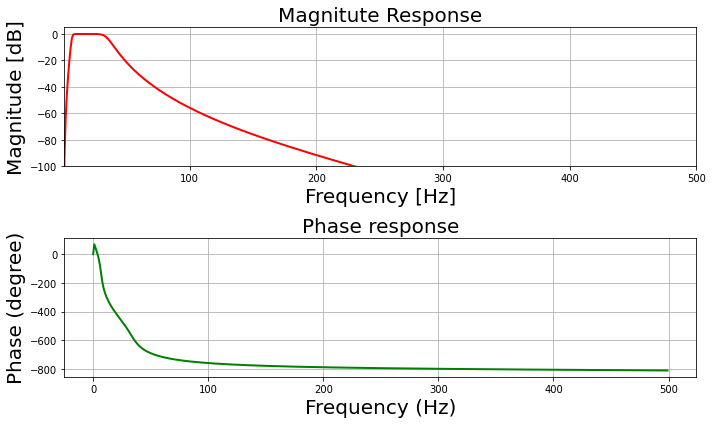

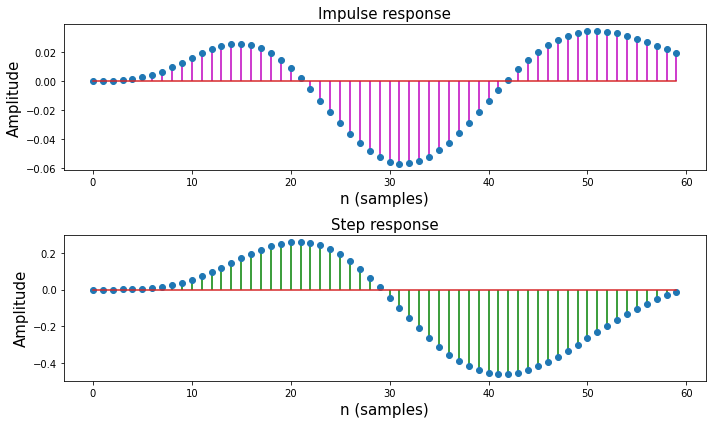

In [ ]:
# import required library
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Compute magnitude and phase response
# using mfreqz function
def mfreqz(b, a, Fs):

	# Compute frequency response of the filter
	# using signal.freqz function
	wz, hz = signal.freqz(b, a)

	# Calculate Magnitude from hz in dB
	Mag = 20*np.log10(abs(hz))

	# Calculate phase angle in degree from hz
	Phase = np.unwrap(np.arctan2(np.imag(hz), np.real(hz)))*(180/np.pi)

	# Calculate frequency in Hz from wz
	Freq = wz*Fs/(2*np.pi)

	# Plot filter magnitude and phase responses using subplot.
	fig = plt.figure(figsize=(10, 6))

	# Plot Magnitude response
	sub1 = plt.subplot(2, 1, 1)
	sub1.plot(Freq, Mag, 'r', linewidth=2)
	sub1.axis([1, Fs/2, -100, 5])
	sub1.set_title('Magnitute Response', fontsize=20)
	sub1.set_xlabel('Frequency [Hz]', fontsize=20)
	sub1.set_ylabel('Magnitude [dB]', fontsize=20)
	sub1.grid()

	# Plot phase angle
	sub2 = plt.subplot(2, 1, 2)
	sub2.plot(Freq, Phase, 'g', linewidth=2)
	sub2.set_ylabel('Phase (degree)', fontsize=20)
	sub2.set_xlabel(r'Frequency (Hz)', fontsize=20)
	sub2.set_title(r'Phase response', fontsize=20)
	sub2.grid()

	plt.subplots_adjust(hspace=0.5)
	fig.tight_layout()
	plt.show()

# Define impz(b,a) to calculate impulse response
# and step response of a system
# input: b= an array containing numerator coefficients,
# a= an array containing denominator coefficients
def impz(b, a):

	# Define the impulse sequence of length 60
	impulse = np.repeat(0., 60)
	impulse[0] = 1.
	x = np.arange(0, 60)

	# Compute the impulse response
	response = signal.lfilter(b, a, impulse)

	# Plot filter impulse and step response:
	fig = plt.figure(figsize=(10, 6))
	plt.subplot(211)
	plt.stem(x, response, 'm', use_line_collection=True)
	plt.ylabel('Amplitude', fontsize=15)
	plt.xlabel(r'n (samples)', fontsize=15)
	plt.title(r'Impulse response', fontsize=15)

	plt.subplot(212)
	step = np.cumsum(response) # Compute step response of the system

	plt.stem(x, step, 'g', use_line_collection=True)
	plt.ylabel('Amplitude', fontsize=15)
	plt.xlabel(r'n (samples)', fontsize=15)
	plt.title(r'Step response', fontsize=15)
	plt.subplots_adjust(hspace=0.5)

	fig.tight_layout()
	plt.show()
 
def filterButter(Fs, fp, fs, Ap, As):
  wp = fp/(Fs/2)
  ws = fs/(Fs/2)
  N, wc = signal.buttord(wp, ws, Ap, As, analog=True)
  print('Order of the filter=', N)
  print('Cut-off frequency=', wc)
  z, p = signal.butter(N, wc, 'bandpass')
  print('Numerator Coefficients:', z)
  print('Denominator Coefficients:', p)
  wz, hz = signal.freqz(z, p)
  mfreqz(z, p, Fs)
  impz(z, p) 
  return z, p


# Given specification
Fs = 1000 # Sampling frequency in Hz
fp = np.array([8, 30]) # Pass band frequency in Hz
fs = np.array([1, 35]) # Stop band frequency in Hz
Ap = 0.4 # Pass band ripple in dB
As = 3 # stop band attenuation in dB 

b, a=filterButter(Fs, fp, fs, Ap, As)

In [ ]:
def dataCollect(fileName):
  with h5py.File(fileName, 'r') as hf:
    ls = list(hf.keys())
  # data = hf.get(ls[0])
  # data = np.array(data)
  # print(data)
    data_raw = hf.get('98:D3:91:FD:57:5B/raw/channel_4')
  # 98:D3:91:FD:57:5B
  # 98:D3:31:FC:99:0D
    data_raw = np.array(data_raw).tolist()
    new_data = []
    for element in data_raw:
      new_data.extend(element)

  new_data = (((np.array(new_data) / 2**10) - 0.5) * 3e6) / 41780
  new_data = new_data.tolist()
  return new_data

def dataCollectFiltered(fileName):
  with h5py.File(fileName, 'r') as hf:
    ls = list(hf.keys())
    data_raw = hf.get(ls[0])
    data_raw = np.array(data_raw)
  data = data_raw.tolist()
  return data

def plotSinyal(new_data, sr = 1000):
  plt.style.use('seaborn-poster')
  %matplotlib inline
  # sampling interval
  N = len(new_data)
  T = 1/sr
  t = np.linspace(0.0, N*T, N, endpoint=False)

  plt.figure(figsize = (500, 4))
  plt.plot(t, new_data, 'r')
  plt.ylabel('Amplitude')
  plt.show()

In [ ]:
#Perlu diubah
path = '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Fattah/Syllaby'
eeg_filtered_dir = os.path.join(path, 'EEG_Filtered')

if not os.path.exists(eeg_filtered_dir):
    os.makedirs(eeg_filtered_dir)

In [ ]:
path_simpan = eeg_filtered_dir
path_eeg = os.path.join(path, "EEG")
formats_to_filter = ['.h5']
folder_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',\
               '13', '14', '15']

for folder in folder_list:
  path_data = os.path.join(path_eeg, folder)
  for (dirpath, dirnames, filenames) in os.walk(path_data):
    for filename in filenames:
      if filename.endswith(tuple(formats_to_filter)):
        try:
          path_file = '{}/{}'.format(path_data, filename)
          data = dataCollect(path_file)
          filtered_signal = signal.filtfilt(b, a, data)
        
          judulFile = "{}.h5".format(str(folder))
          path_simpan_dir = os.path.join(path_simpan, judulFile)

          with h5py.File(path_simpan_dir, 'w') as hf:
            hf.create_dataset(judulFile, data=filtered_signal)
        except:
          print(os.path.join(dirpath, filename))

print("Filtered data created")

/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Fattah/Syllaby/EEG/13/in/opensignals_98D391FD575B_2021-08-06_09-42-45.h5
Filtered data created


In [ ]:
path_file = '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Fattah/Syllaby/EEG/13/in/opensignals_98D391FD575B_2021-08-06_09-42-45.h5'
path_simpan = '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Fattah/Syllaby/EEG_Filtered'

data = dataCollect(path_file)
filtered_signal = signal.filtfilt(b, a, data)
        
judulFile = "{}_{}.h5".format(str(13), 'in')
path_simpan_dir = os.path.join(path_simpan, judulFile)

with h5py.File(path_simpan_dir, 'w') as hf:
  hf.create_dataset(judulFile, data=filtered_signal)

In [ ]:
data = dataCollect('/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Bos/Syllaby/EEG/3/opensignals_98D391FD575B_2021-07-29_10-10-45.h5')

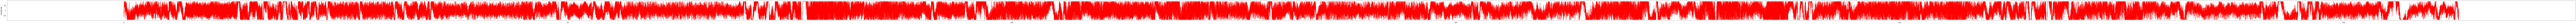

In [ ]:
plotSinyal(data)

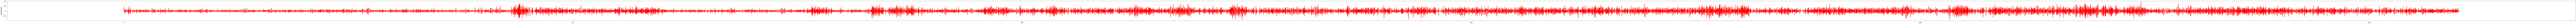

In [ ]:
data = dataCollectFiltered('/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Bos/Syllaby/EEG_Filtered/1.h5')
plotSinyal(data)

# Program potong-potong data syllaby

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install pydub

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pydub import AudioSegment
import os
import argparse

Convert m4a to wav

In [ ]:
formats_to_convert = ['.m4a']

# Perlu diubah
for (dirpath, dirnames, filenames) in os.walk("/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Fabian"):
    for filename in filenames:
        if filename.endswith(tuple(formats_to_convert)):

            filepath = dirpath + '/' + filename
            (path, file_extension) = os.path.splitext(filepath)
            file_extension_final = file_extension.replace('.', '')
            try:
                track = AudioSegment.from_file(filepath,
                        file_extension_final)
                wav_filename = filename.replace(file_extension_final, 'wav')
                wav_path = dirpath + '/' + wav_filename
                print('CONVERTING: ' + str(filepath))
                file_handle = track.export(wav_path, format='wav')
                os.remove(filepath)
            except:
                print("ERROR CONVERTING " + str(filepath))

Convert to time series data

In [ ]:
import soundfile as sf

In [ ]:
def konversi_time_series(file_dir):
  data, fs = sf.read(file_dir) 
  T = 1/fs
  t = [k*T for k in range(len(data))]
  return data, t, T

In [ ]:
from scipy.signal import find_peaks

Compare sound with eeg

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

def dataCollect(fileName):
  with h5py.File(fileName, 'r') as hf:
    ls = list(hf.keys())
  # data = hf.get(ls[0])
  # data = np.array(data)
  # print(data)
    data_raw = hf.get('98:D3:31:FC:99:0D/raw/channel_4')
  # 98:D3:91:FD:57:5B
  # 98:D3:31:FC:99:0D
    data_raw = np.array(data_raw).tolist()
    new_data = []
    for element in data_raw:
      new_data.extend(element)
    print(new_data)

  new_data = (((np.array(new_data) / 2**10) - 0.5) * 3e6) / 41780
  new_data = new_data.tolist()
  return new_data

def dataCollectFiltered(fileName):
  with h5py.File(fileName, 'r') as hf:
    ls = list(hf.keys())
    data_raw = hf.get(ls[0])
    data_raw = np.array(data_raw)
  data = data_raw.tolist()
  return data

def plotSinyal(new_data, sr = 1000):
  plt.style.use('seaborn-poster')
  %matplotlib inline
  # sampling interval
  N = len(new_data)
  T = 1/sr
  t = np.linspace(0.0, N*T, N, endpoint=False)

  plt.figure(figsize = (100, 20))
  plt.plot(t, new_data, 'r')
  plt.ylabel('Amplitude')
  plt.show()

['98:D3:91:FD:57:5B']


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



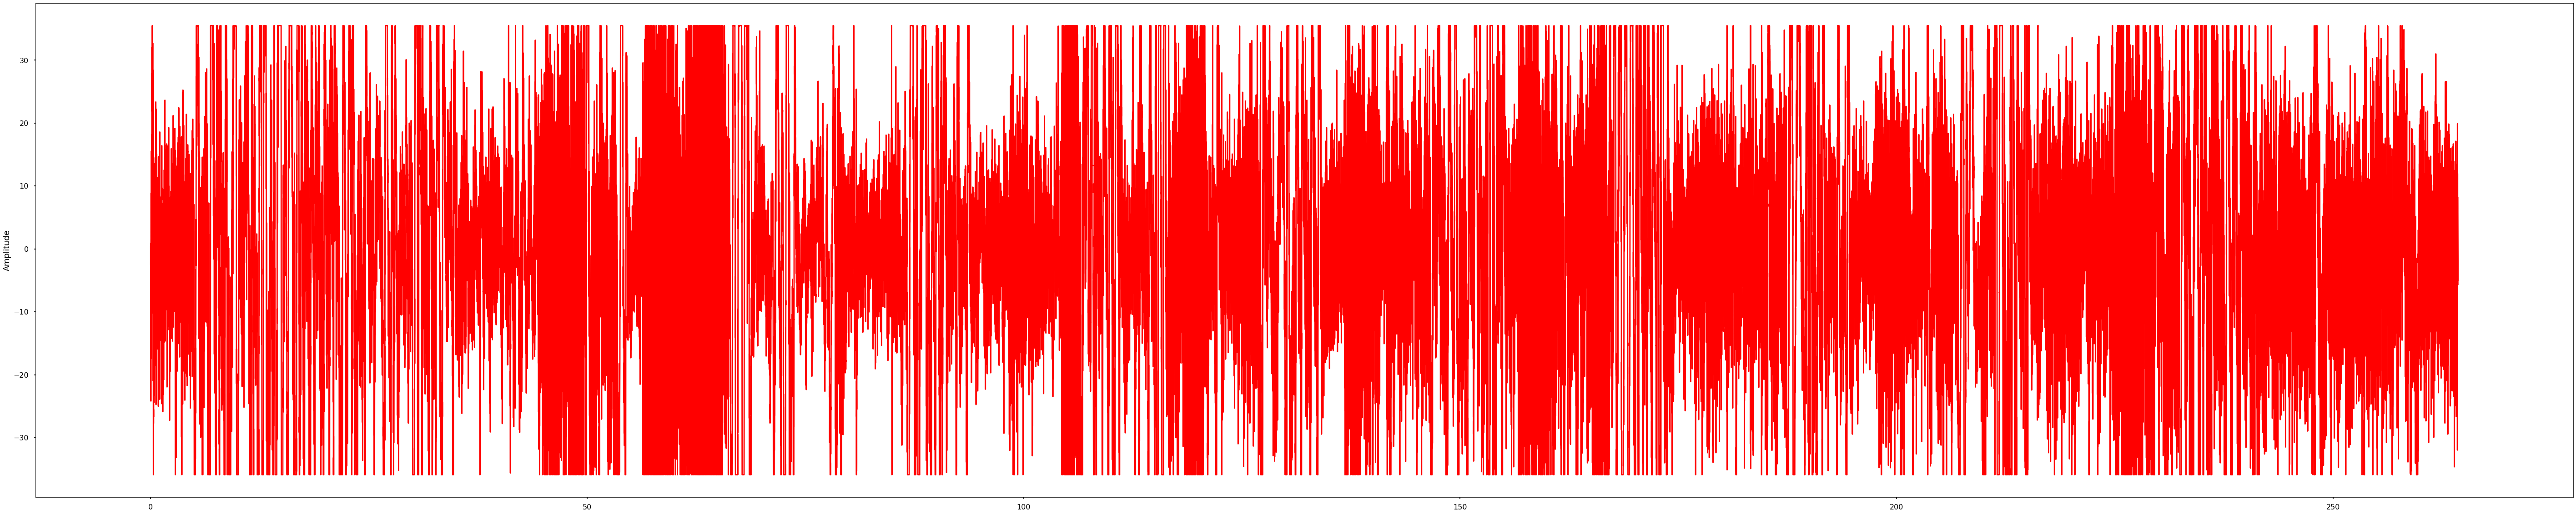

In [ ]:
new_data = dataCollect('/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Bos/Syllaby/EEG/6/opensignals_98D391FD575B_2021-07-30_08-31-33.h5')
plotSinyal(new_data)

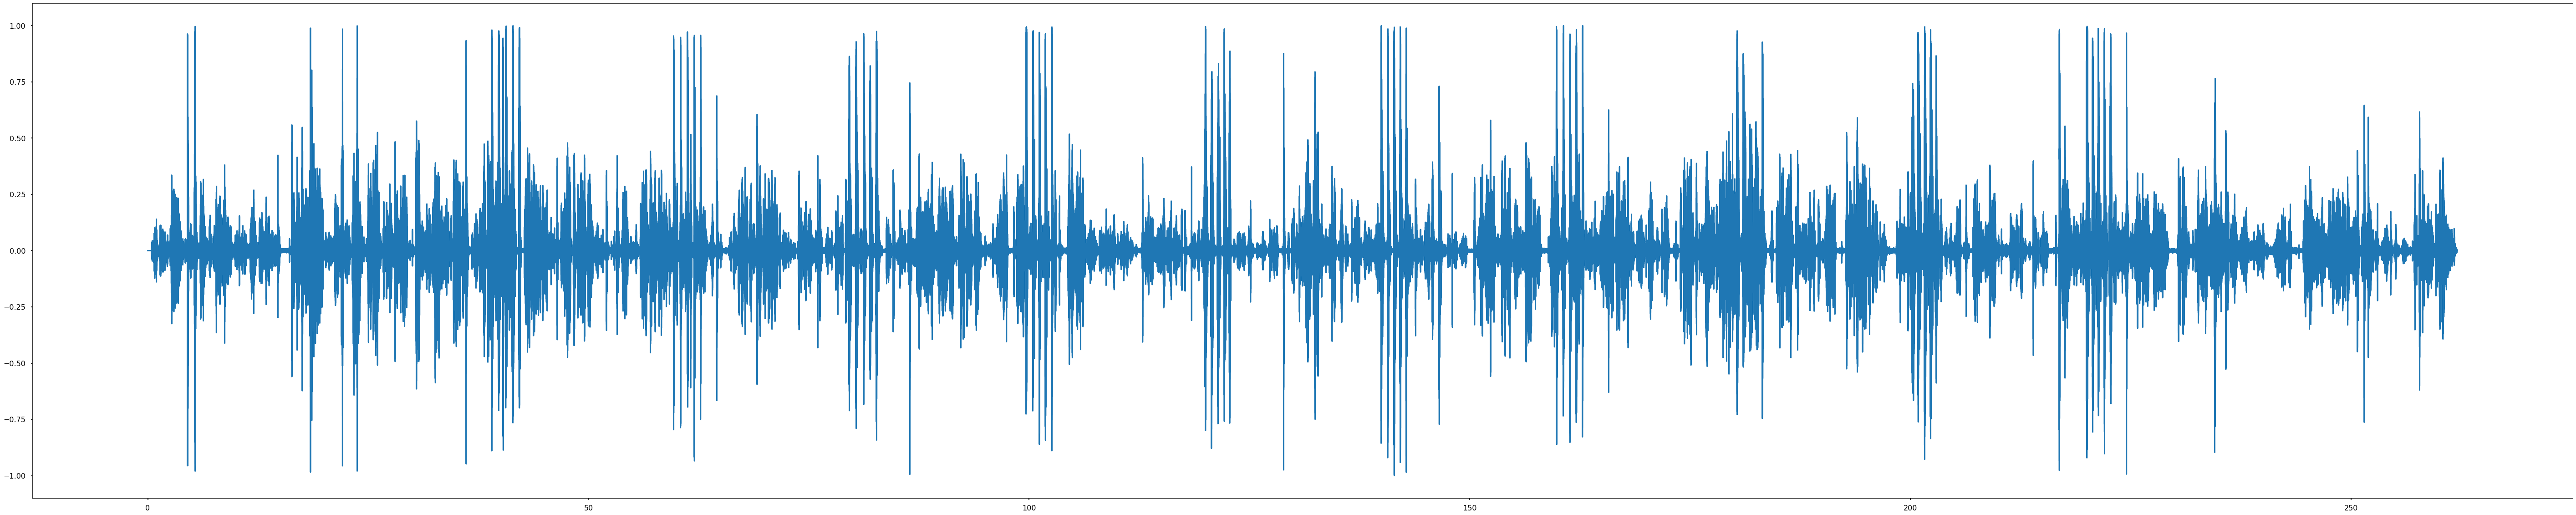

In [ ]:
data, t, T = konversi_time_series('/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Bos/Syllaby/Suara/6.wav')

plt.figure(figsize = (100, 20))
plt.plot(t,data[:,0])
plt.show()

Splitting eeg and sound data

In [ ]:
list_syllaby = ['a', 'ku', 'ki', 'ta', 'ma', 'in', 'kan', 'bo', 'la', 'yam']
fs = 1000

def caridict(syllaby_peak, fs, T, list_syllaby):
  iteration = 0
  detik_dict = {"detik_awal_bicara_a": syllaby_peak[0]*T,
                "detik_awal_visualisasi_a": (syllaby_peak[0]*T)-5}
  indeks_eeg = {}
  detik_istirahat_suara = {}
  indeks_istirahat_eeg = {}

  for syllaby in list_syllaby[1:]:
    detik_dict["detik_awal_visualisasi_{}".format(syllaby)] = detik_dict["detik_awal_bicara_{}".format(list_syllaby[iteration])] + 15
    detik_dict["detik_awal_bicara_{}".format(syllaby)] = detik_dict["detik_awal_bicara_{}".format(list_syllaby[iteration])] + 20
    iteration += 1
  print(detik_dict)

  iteration = 0
  for syllaby in list_syllaby:
    indeks_eeg["indeks_awal_visualisasi_{}_eeg".format(syllaby)] = round(detik_dict["detik_awal_visualisasi_{}".format(syllaby)]*fs)
    indeks_eeg["indeks_awal_bicara_{}_eeg".format(syllaby)] = round(detik_dict["detik_awal_bicara_{}".format(syllaby)]*fs)
    detik_istirahat_suara["detik_awal_istirahat_{}_suara".format(syllaby)] = int(detik_dict["detik_awal_bicara_{}".format(list_syllaby[iteration])] + 5)
    indeks_istirahat_eeg["indeks_awal_istirahat_{}_eeg".format(syllaby)] = round((detik_dict["detik_awal_bicara_{}".format(list_syllaby[iteration])] + 5)*fs)
    iteration += 1
  print(indeks_eeg)
  print(detik_istirahat_suara)
  print(indeks_istirahat_eeg)

  return detik_dict, indeks_eeg, detik_istirahat_suara, indeks_istirahat_eeg

# suara_ku = AudioSegment.from_wav("/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Bos/Syllaby/Suara/15.wav")
# suara_ku = suara_ku[(detik_dict["detik_awal_bicara_ku"]*1000):(detik_istirahat_suara["detik_awal_istirahat_ki_suara"]-1)*1000]
# suara_ku.export('suara_ku.wav', format="wav")

In [ ]:
print(t[-1])

In [ ]:
def suara_trim(path_suara, path_simpan, indeks_syllaby, mode, folder, detik_dict, detik_istirahat_suara):
  suara = AudioSegment.from_wav(path_suara)
  t_awal_visualisasi = detik_dict["detik_awal_visualisasi_{}".format(list_syllaby[indeks_syllaby])]
  t_awal_istirahat = detik_istirahat_suara["detik_awal_istirahat_{}_suara".format(list_syllaby[indeks_syllaby])]
  t_awal_bicara = detik_dict["detik_awal_bicara_{}".format(list_syllaby[indeks_syllaby])]
  if mode == "bicara":
    suara = suara[t_awal_bicara*1000 : (t_awal_istirahat-1)*1000]
  elif mode == "visualisasi":
    suara = suara[t_awal_visualisasi*1000 : (t_awal_bicara-1)*1000]
  else:
    raise Exception("Mode tidak diketahui")
  suara.export('{}/{}_{}_{}.wav'.format(path_simpan,str(folder), mode, list_syllaby[indeks_syllaby]), format="wav")

def eeg_trim(path_eeg, path_simpan, indeks_syllaby, mode, folder, indeks_eeg, indeks_istirahat_eeg):
  data = dataCollectFiltered(path_eeg)
  t_awal_visualisasi = indeks_eeg["indeks_awal_visualisasi_{}_eeg".format(list_syllaby[indeks_syllaby])]
  t_awal_istirahat = indeks_istirahat_eeg["indeks_awal_istirahat_{}_eeg".format(list_syllaby[indeks_syllaby])]
  t_awal_bicara = indeks_eeg["indeks_awal_bicara_{}_eeg".format(list_syllaby[indeks_syllaby])]
  if mode == "bicara":
    data = data[t_awal_bicara : t_awal_istirahat-1]
  elif mode == "visualisasi":
    data = data[t_awal_visualisasi : t_awal_bicara-1]
  else:
    raise Exception("Mode tidak diketahui")
  
  path = os.path.join(path_simpan,str(folder))
  if not os.path.exists(path):
    os.makedirs(path)

  judulFile = "{}_{}_{}.h5".format(str(folder), mode, list_syllaby[indeks_syllaby])
  path = os.path.join(path, judulFile)

  with h5py.File(path, 'w') as hf:
    hf.create_dataset(judulFile, data=data)

In [ ]:
#Perlu diubah

path = '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Bos/Syllaby'
eeg_trimmed_dir = os.path.join(path, 'EEG_Trimmed')
suara_trimmed_dir = os.path.join(path, 'Suara_Trimmed')

if not os.path.exists(eeg_trimmed_dir):
    os.makedirs(eeg_trimmed_dir)

if not os.path.exists(suara_trimmed_dir):
    os.makedirs(suara_trimmed_dir)

# contoh_path_suara = '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Bos/Syllaby/Suara/15.wav'
# suara_trim(contoh_path_suara, suara_trimmed_dir, 1, "bicara", 1)

# contoh_path_eeg = '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Bos/Syllaby/EEG/15/opensignals_98D391FD575B_2021-07-30_09-58-30.h5'
# eeg_trim(contoh_path_eeg, eeg_trimmed_dir, 1, "bicara", 15)

Otomatisasi potong2 data

In [ ]:
def findPeak(data, T, max=75000, min=11000):
  peaks, _ = find_peaks(data, height=0.75, distance=10000)
  pronounced_syllaby = 0
  iteration = 0
  indeks_data = peaks
  syllaby_peak = []
  for syllaby in peaks:
    if indeks_data[iteration] >= 35.0:
      pronounced_syllaby += 1
      if pronounced_syllaby < 5:
        if peaks[iteration+1] - syllaby >= max or peaks[iteration+1] - syllaby <= min:
          print(str(peaks[iteration+1]) + " - " + str(syllaby) + " = " + str(peaks[iteration+1] - syllaby))
          pronounced_syllaby = 0
        else:
          syllaby_peak.append(syllaby)
      else:
        syllaby_peak.append(syllaby)
        pronounced_syllaby = 0
        break
    iteration += 1
  print(syllaby_peak)
  return syllaby_peak

In [ ]:
def plotPeak(path):
  data, t, T = konversi_time_series(path)
  syllaby_peak = findPeak(data[:,0], T)
  plt.figure(figsize = (100, 20))
  plt.plot(data[:,0])
  plt.plot(syllaby_peak, data[syllaby_peak,0], "o")
  plt.show()

[857705, 890794, 925159, 960997, 994643]


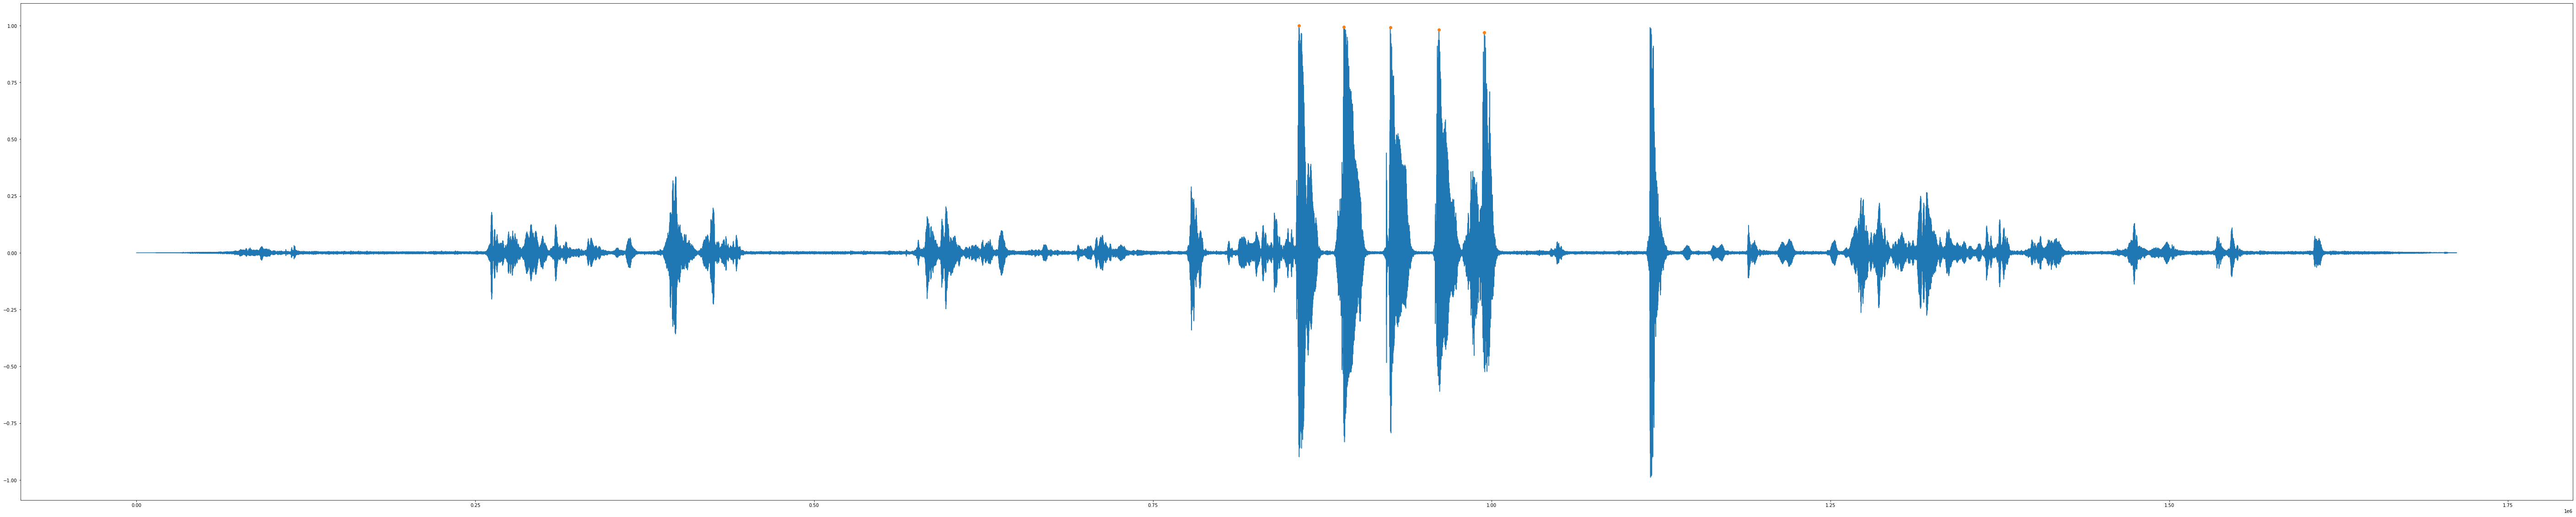

In [ ]:
# Path perlu diubah
# Cek Peak 

iteration = '14_bo'
plotPeak('/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Bos/Syllaby/Suara/{}.wav'.format(iteration))

In [ ]:
path_simpan = suara_trimmed_dir
path_suara = os.path.join(path, "Suara")
mode = ["bicara", "visualisasi"]
list_syllaby = ['a', 'ku', 'ki', 'ta', 'ma', 'in', 'kan', 'bo', 'la', 'yam']
folder_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for folder in folder_list:
  try:
    path_file = "{}/{}.wav".format(path_suara, folder)
    data, t, T = konversi_time_series(path_file)
    syllaby_peak = findPeak(data[:,0], T)
    detik_dict, indeks_eeg, detik_istirahat_suara, indeks_istirahat_eeg = caridict(syllaby_peak, fs, T, list_syllaby)
    for cara in mode:
      for indeks_syllaby in range (len(list_syllaby)):
        suara_trim(path_file, path_simpan, indeks_syllaby, cara, folder, detik_dict, detik_istirahat_suara)
        print(folder, cara, list_syllaby[indeks_syllaby] + " created")
  except Exception as err:
    print(path_file)
    print(err)

[1777727, 1805468, 1833862, 1864576, 1897114]
{'detik_awal_bicara_a': 37.035979166666664, 'detik_awal_visualisasi_a': 32.035979166666664}
/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Bos/Syllaby/Suara/14.wav
'detik_awal_visualisasi_bo'


In [ ]:
path_simpan = eeg_trimmed_dir
path_eeg = os.path.join(path, "EEG_Filtered")
mode = ["bicara", "visualisasi"]
list_syllaby = ['a', 'ku', 'ki', 'ta', 'ma', 'in', 'kan', 'bo', 'la', 'yam']
formats_to_convert = ['.h5']
folder_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',\
               '13', '14', '15']

# ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',\
#               '13', '14', '15']

for folder in folder_list:
  path_file = '{}/{}.h5'.format(path_eeg, folder)
  print(path_file)
  path_file_suara = "{}/{}.wav".format(path_suara, folder)
  data, t, T = konversi_time_series(path_file_suara)
  syllaby_peak = findPeak(data[:,0], T)
  detik_dict, indeks_eeg, detik_istirahat_suara, indeks_istirahat_eeg = caridict(syllaby_peak, fs, T, list_syllaby)
  for cara in mode:
    for indeks_syllaby in range (len(list_syllaby)):
      eeg_trim(path_file, path_simpan, indeks_syllaby, cara, folder, indeks_eeg=indeks_eeg, indeks_istirahat_eeg=indeks_istirahat_eeg)
      print(folder, cara, list_syllaby[indeks_syllaby] + " created")
#        print(dirpath)

In [ ]:
path_file = '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Fattah/Syllaby/EEG_Filtered/13_in.h5'
path_simpan = eeg_trimmed_dir
path_suara = os.path.join(path, "Suara")
list_syllaby = ['a', 'ku', 'ki', 'ta', 'ma', 'in', 'kan', 'bo', 'la', 'yam']
mode = ["bicara", "visualisasi"]
path_file_suara = "{}/{}.wav".format(path_suara, "13_in")
data, t, T = konversi_time_series(path_file_suara)
syllaby_peak = findPeak(data[:,0], T)
detik_dict, indeks_eeg, detik_istirahat_suara, indeks_istirahat_eeg = caridict(syllaby_peak, fs, T, list_syllaby)


eeg_trim(path_file, path_simpan, 5, "bicara", 13, indeks_eeg=indeks_eeg, indeks_istirahat_eeg=indeks_istirahat_eeg)
print(13, "bicara", list_syllaby[5] + " created")

eeg_trim(path_file, path_simpan, 5, "visualisasi", 13, indeks_eeg=indeks_eeg, indeks_istirahat_eeg=indeks_istirahat_eeg)
print(13, "visualisasi", list_syllaby[5] + " created")

# Fitur Ekstraksi DWT

In [ ]:
fs = 256
for i in range(7):
  fs = fs/2
  print(fs)

print('\n')

fs = 1000
for i in range(9):
  fs = fs/2
  print(fs)

In [ ]:
element = [-0.09498382095883902, -0.004462786114206241, 0.036182813270629804, -0.0016517938583132802, -0.011169403833921556, 0.0035621794157200556, 1.8973203671313944e-05, 4.207579612753028e-05, -0.00012514601109773026, 0.00021956312917967806, -0.00030774310977616155, 0.00038500648223772476, -0.00042865830917097273, 0.0004425196487246915, -0.0004086287955724618, 0.00033828496016634086, -0.0002263489376439931, 8.734956223991757e-05, 6.80497256498773e-05, -0.00022792900477966042, 0.0003693534161639149, -0.0004880995217586697, 0.0005577597975430684, -0.0005840536174876199, 0.000547693417478837, -0.0004627548825985652, 0.00032521972026662907, -0.0001525861844119827, -4.144708246521618e-05, 0.00024245036680111272, -0.00042337717141096795, 0.0005784540191999919, -0.0006770467925803122, 0.0007245274250561905, -0.0006982100639095074, 0.000612978812304549, -0.0004628983180182823, 0.00026719442964950825, -3.925002116773222e-05, -0.00020413374043071837, 0.0004349075506610577, -0.0006445576001575975, 0.0008003853640609818, -0.0009050284589983259, 0.0009327079795659364, -0.0008961332689252021, 0.0007853432278873403, -0.0006185759424848426, 0.0004048453670584218, -0.00016159354239744745, -8.67268585784698e-05, 0.0003292949158619037, -0.0005350841453518406, 0.0007031526006801177, -0.0008068448506546558, 0.0008547049948040958, -0.0008334516179632207, 0.0007573742334883139, -0.0006303725951563756, 0.0004669378799947183, -0.00028554323938450167, 9.569390294003542e-05, 7.733923187066291e-05, -0.00023194474088255505, 0.000345830031545299, -0.0004249366250389037, 0.0004579579514042875, -0.0004550830099222594, 0.00041935763406190506, -0.0003603280545547887, 0.0002930528343626819, -0.0002219555428194566, 0.00016700354788773931, -0.00012532240253699858, 0.00011266818423871302, -0.00012000615234737143, 0.00015149484379794328, -0.00019602815864620492, 0.00024373396353101433, -0.00028684809473890317, 0.00030519219508690684, -0.0002988313081548986, 0.0002458234713459395, -0.0001556385477361715, 1.459218282592123e-05, 0.00016070108244263003, -0.0003682308555648977, 0.0005897753269645228, -0.000806029873326221, 0.0010040463169860184, -0.0011526422820092544, 0.001249731136853519, -0.001263096439821356, 0.0012035173500781588, -0.0010500206564022605, 0.0008236860631137007, -0.0005236793368727504, 0.00017499414936923328, 0.00020117869218989272, -0.0005839295051329019, 0.0009361229366514744, -0.0012477203291618086, 0.001477588327531871, -0.0016297634975589634, 0.0016726391077442272, -0.0016228717077003663, 0.001468703049416736, -0.0012338520189644957, 0.0009299922632822445, -0.0005802101303361045, 0.00021530387617076107, 0.0001494171247521389, -0.00047466709142721624, 0.0007570572145745872, -0.0009619699827767441, 0.0010977854080394837, -0.0011454741476957162, 0.001121063044556637, -0.0010259830736547393, 0.0008775465496841052, -0.0006951138525178558, 0.000491089775127357, -0.0002942409284827515, 0.000108238007390394, 3.9872642327755194e-05, -0.00015536455635557049, 0.00022257908536714105, -0.000252418212411688, 0.0002454427313045904, -0.00021274193578493399, 0.0001694388959494355, -0.00012149203519721814, 9.110080239124136e-05, -7.613903347572359e-05, 9.557356744607802e-05, -0.00013986874413457023, 0.0002159880980339698, -0.00031099995078973737, 0.00041640328824031327, -0.0005215344685747425, 0.0006056703359302665, -0.0006653955613025457, 0.0006762650724432491, -0.000644363558828868, 0.0005518118905917146, -0.0004127371021388511, 0.00022381020257830115, -2.4760905051956787e-06, -0.00023753617212788212, 0.00048174711172737966, -0.0007034598619756273, 0.0008966120868968225, -0.0010309478811424606, 0.0011112483123142721, -0.0011150117895124836, 0.0010561979103970143, -0.0009287837989395136, 0.0007507347578015736, -0.0005349795892707323, 0.0002968174717891526, -6.32639141789526e-05, -0.00015862272722933288, 0.00033801672629603515, -0.00047841927597784767, 0.0005568762954794174, -0.0005855999255325136, 0.0005581130896195893, -0.0004900081236119899, 0.0003934795261444764, -0.0002807573707120251, 0.00017750356623108396, -8.714672453326382e-05, 3.806007264486586e-05, -2.3022632089023017e-05, 6.101257367604464e-05, -0.00013678276455669872, 0.0002514352071973714, -0.0003878425835976833, 0.0005280114834909347, -0.0006601832058944582, 0.0007539875453644504, -0.0008084927299234916, 0.000792978454825888, -0.0007188153042134066, 0.0005674894650548941, -0.0003594960899260642, 9.674756634632783e-05, 0.00019792349934220777, -0.0005014083037165262, 0.0007965621168698719, -0.0010461899740083732, 0.0012452085555660856, -0.0013549824371852307, 0.0013848446591052102, -0.001308427160840722, 0.0011468818660650866, -0.0008958433079096304, 0.0005815950302971222, -0.00022392351074246655, -0.0001542119438583884, 0.0005151044022941758, -0.000846432790578584, 0.0011049386605420568, -0.0012926484835419536, 0.0013749125113706108, -0.0013670183479047237, 0.0012540428440945826, -0.0010591045084951671, 0.0007913746777409652, -0.0004739771891277224, 0.00013634879023750513, 0.00020580916096488074, -0.0005134520216470321, 0.000782717802395872, -0.0009785359037641063, 0.001108857292746668, -0.0011540803507813437, 0.0011297713463174898, -0.0010370897651495632, 0.0008926687406831421, -0.0007158690641349865, 0.0005181088878554455, -0.00032792111639176293, 0.0001478699192481604, -3.948155916293568e-06, -0.00010989479576647766, 0.00017998206468961833, -0.00021718378534948553, 0.00022433984446034957, -0.00021148391260503567, 0.00019524447551556306, -0.00017968853020759723, 0.00018691138681021109, -0.0002125564609157316, 0.0002737451379104619, -0.00035897348528401464, 0.0004721271050252168, -0.0005991045449858873, 0.0007278996701173871, -0.0008478426658035033, 0.0009351326509445118, -0.0009876273506621877, 0.0009790152905437678, -0.0009177403401445182, 0.0007858698417804897, -0.0006004585331093025, 0.00036020387299988806, -8.52904890735213e-05, -0.00020672292528434248, 0.0004995863200564965, -0.0007618862179086415, 0.0009873080795347975, -0.0011412987529652576, 0.0012300554040651792, -0.0012284164203750882, 0.0011531508161954117, -0.0009979600468184606, 0.0007843960431967265, -0.0005276291478903457, 0.00024650069367216385, 2.7645397998758747e-05, -0.00028512997266088837, 0.0004895723296247362, -0.0006435515212086982, 0.000718475896566376, -0.0007278527367892309, 0.000660763949901614, -0.0005364156032988916, 0.0003650029947927882, -0.00016424481562744554, -3.8779940634587476e-05, 0.00023430905255593547, -0.0003887347759392228, 0.0005036047486528578, -0.000551372691168345, 0.0005439433963753663, -0.00046988203024183353, 0.0003466556116888949, -0.00018270896862335604, -5.674933844749776e-06, 0.00019392156351752981, -0.0003730716751196343, 0.0005120697424488315, -0.0006125389766054526, 0.0006487863330205478, -0.0006322144737233872, 0.0005521308448289865, -0.00042519408538807914, 0.0002595692943187067, -7.069249676737521e-05, -0.00011781256470642588, 0.0002976307480674131, -0.0004390314454855116, 0.0005438502352654375, -0.0005878314950376694, 0.000582009888665558, -0.0005168154776781905, 0.00040801852816270575, -0.00026404822627331884, 9.923144973569949e-05, 6.36600720474663e-05, -0.00021726298234642607, 0.0003334577786946838, -0.0004146522016679438, 0.00043818932064667297, -0.00041533900317909086, 0.00033748895852124056, -0.00022050981079268416, 7.309768311550979e-05, 9.032369006020908e-05, -0.0002469218504175915, 0.0003893205614430007, -0.0004890561801527855, 0.0005488267160380875, -0.0005453428613261524, 0.0004906250005784653, -0.0003756097898279096, 0.00021734051287527318, -2.473956350198575e-05, -0.00018636463305719985, 0.00039213331278442165, -0.0005837614996679937, 0.0007312664629390074, -0.0008360464058233133, 0.0008730927708134477, -0.0008533737527976289, 0.0007660775789534217, -0.0006275541231959346, 0.000445067067076146, -0.00023420380459722638, 1.738264294472817e-05, 0.00019629656284722937, -0.0003779434162871389, 0.0005280070744434228, -0.0006222443054049538, 0.0006698646922924313, -0.0006604007574378001, 0.0006075614275672422, -0.000518132162933805, 0.0004043617201859387, -0.00028679959933021037, 0.00017100331996204525, -8.23572742793976e-05, 1.7331705617049308e-05, 4.578816933525603e-06, 5.429785951048443e-06, -5.2696303529613185e-05, 0.0001230958476727881, -0.000205257864881366, 0.0002883683920431485]

# for element in list_coba:
print(element)
print(stat.mean(element))
print(stat.median(element))
try:
  print(stat.mode(element))
except:
  pass
print(stat.stdev(element))
print(max(element)-min(element))

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# !pip install statistics

from statistics import mean, median, mode, stdev
import os
import csv
import h5py
import pywt
import numpy as np

In [ ]:
!git clone https://github.com/izlotnik/wavelet-wrcoef.git
!cp /content/wavelet-wrcoef/wrcoef.py /content

import wrcoef

fatal: destination path 'wavelet-wrcoef' already exists and is not an empty directory.


In [ ]:
# Seusaikan level sama WAVELET

def featureDWT(new_data, WAVELET = 'db4', LEVEL = 9, sr = 1000):
  C, L = wrcoef.wavedec(new_data, pywt.Wavelet(WAVELET), mode = 'zero', level = LEVEL)
  X = []
  for i in range(1, LEVEL + 1):
    X1 = wrcoef.wrcoef(C, L, pywt.Wavelet(WAVELET), level=i)
    listDWT = X1.tolist()
    X.append(listDWT)

  return X

In [ ]:
def dataCollect(fileName):
  with h5py.File(fileName, 'r') as hf:
    ls = list(hf.keys())
    data_raw = hf.get(ls[0])
    data_raw = np.array(data_raw)
  # data = data_raw.tolist()
  # dataSWT = (filterSWT(data_raw.tolist())).tolist()
  return data_raw

In [ ]:
# Buat feature_dir baru kl mau buat file feature baru

path = '/content/drive/MyDrive/PKM_KC_EEG_2021'
feature_dir = os.path.join(path, 'feature_stat_5')

if not os.path.exists(feature_dir):
    os.makedirs(feature_dir)

# Perlu diubah list_syllaby

list_syllaby = ['a', 'ku', 'ma', 'kan']
for dir in os.listdir('/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG'):
  path_person = os.path.join(feature_dir, dir)
  if not os.path.exists(path_person):
    os.makedirs(path_person)

In [ ]:
def listFeatureMean(syllaby, mode, path):
  formats_to_convert = ['{}_{}.h5'.format(mode, syllaby)]
  eror = []
  feature = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
      if filename.endswith(tuple(formats_to_convert)):
        # try:
        path_file = os.path.join(dirpath, filename)
        data = dataCollect(path_file)
        if len(data) <= 0:
          print(path_file)
          break
        dataDWT = featureDWT(data)
        for element in dataDWT:
          data_stat = mean(element)
          feature.append(data_stat)
        # except Exception as err:
        #   print("Eror di feature extraction {}_{}_{}".format("mean", syllaby, cara))
        #   print(err)
        #   print(path_file)
        #   data_stat = -1
        #   eror.append(err)
        #   feature.append(data_stat)
  return feature, path_file, eror

def listFeatureMedian(syllaby, mode, path):
  formats_to_convert = ['{}_{}.h5'.format(mode, syllaby)]
  eror = []
  feature = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
      if filename.endswith(tuple(formats_to_convert)):
        # try:
        path_file = os.path.join(dirpath, filename)
        data = dataCollect(path_file)
        if len(data) <= 0:
          print(path_file)
          break
        dataDWT = featureDWT(data)
        for element in dataDWT:
          data_stat = median(element)
          feature.append(data_stat)
        # except Exception as err:
        #   print("Eror di feature extraction {}_{}_{}".format("median", syllaby, cara))
        #   print(err)
        #   print(path_file)
        #   data_stat = -1
        #   eror.append(err)
        #   feature.append(data_stat)
  return feature, path_file, eror

def listFeatureStd(syllaby, mode, path):
  formats_to_convert = ['{}_{}.h5'.format(mode, syllaby)]
  eror = []
  feature = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
      if filename.endswith(tuple(formats_to_convert)):
        # try:
        path_file = os.path.join(dirpath, filename)
        data = dataCollect(path_file)
        if len(data) <= 0:
          print(path_file)
          break
        dataDWT = featureDWT(data)
        for element in dataDWT:
          data_stat = stdev(element)
          feature.append(data_stat)
        # except Exception as err:
        #   print("Eror di feature extraction {}_{}_{}".format("stdev", syllaby, cara))
        #   print(err)
        #   print(path_file)
        #   data_stat = -1
        #   eror.append(err)
        #   feature.append(data_stat)
  return feature, path_file, eror

def listFeatureRange(syllaby, mode, path):
  formats_to_convert = ['{}_{}.h5'.format(mode, syllaby)]
  eror = []
  feature = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
      if filename.endswith(tuple(formats_to_convert)):
        # try:
        path_file = os.path.join(dirpath, filename)
        data = dataCollect(path_file)
        if len(data) <= 0:
          print(path_file)
          break
        dataDWT = featureDWT(data)
        for element in dataDWT:
          data_stat = max(element) - min(element)
          feature.append(data_stat)
        # except Exception as err:
        #   print("Eror di feature extraction {}_{}_{}".format("range", syllaby, cara))
        #   print(err)
        #   print(path_file)
        #   data_stat = -1
        #   eror.append(err)
        #   feature.append(data_stat)
  return feature, path_file, eror

In [ ]:
path = '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Bos'
feature, path_file, eror = listFeatureMean('a', 'visualisasi', path)

In [ ]:
# Feature_dir diubah sesuai di atas

list_syllaby = ['a', 'ku', 'ma', 'kan']
mode = ['bicara', 'visualisasi']
path = '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG'
feature_dir = os.path.join('/content/drive/MyDrive/PKM_KC_EEG_2021', 'feature_stat_5')
stat = ['mean', 'median', 'std', 'range']
eror = {"mean": [], "median": [], "std": [], "range": [], "csv": []}

for feature in stat:
  for dir in os.listdir(path):
    with open(os.path.join(feature_dir, '{}/Hasil_{}_{}.csv'.format(dir, dir, feature)), mode = 'w') as file:
      data_writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
      data_writer.writerow(['mode', 'Coef Aprox', 'Coef Detail 9', 'Coef Detail 8',\
                            'Coef Detail 7', 'Coef Detail 6', 'Coef Detail 5', 'Coef Detail 4',\
                            'Coef Detail 3' , 'Coef Detail 2', 'Coef Detail 1', 'syllaby'])
      for syllaby in list_syllaby:
        for cara in mode:
          if feature == 'mean':
            data, path_file, errorFeature = listFeatureMean(syllaby, cara, os.path.join(path,dir))
            if errorFeature != []:
              eror["mean"].append([errorFeature, path_file])
          if feature == 'median':
            data, path_file, errorFeature = listFeatureMedian(syllaby, cara, os.path.join(path,dir))
            if errorFeature != []:
              eror["median"].append([errorFeature, path_file])
          # if feature == 'modus':
          #   data, path_file, errorFeature = listFeatureModus(syllaby, cara, os.path.join(path,dir))
          #   if errorFeature != []:
          #     eror["modus"].append([errorFeature, path_file])
          if feature == 'std':
            data, path_file, errorFeature = listFeatureStd(syllaby, cara, os.path.join(path,dir))
            if errorFeature != []:
              eror["std"].append([errorFeature, path_file])
          if feature == 'range':
            data, path_file, errorFeature = listFeatureRange(syllaby, cara, os.path.join(path,dir))
            if errorFeature != []:
              eror["range"].append([errorFeature, path_file])

          data_writer.writerow([cara, data[0], data[1], data[2], data[3],\
                                  data[4], data[5], data[6], data[7], data[8],\
                                  data[9], syllaby])
    print("csv {} created".format(dir))

In [ ]:
# Path feature dan nama file csv diubah yang bener

format_to_contenate = ['.csv']
path = '/content/drive/MyDrive/PKM_KC_EEG_2021'
stat = ['mean', 'median', 'std', 'range']
path_feature = os.path.join(path, 'feature_stat_3')

for feature in stat:
  with open(os.path.join(path, 'Hasil_Feature_Visualisasi_{}_3.csv'.format(feature)), mode = 'w') as file:
    data_writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    data_writer.writerow(['Coef Aprox', 'Coef Detail 9', 'Coef Detail 8',\
                              'Coef Detail 7', 'Coef Detail 6', 'Coef Detail 5', 'Coef Detail 4',\
                              'Coef Detail 3' , 'Coef Detail 2', 'Coef Detail 1', 'syllaby'])
    for (dirpath, dirnames, filenames) in os.walk(path_feature):
      for filename in filenames:
        if filename.endswith(tuple(format_to_contenate)):
          with open(os.path.join(dirpath, filename)) as reader:
            data_reader = csv.reader(reader, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
            line_count = 0
            list_data = []
            for row in data_reader:
              if line_count == 0:
                line_count += 1
              else:
                list_data.append(row)
          for data_row in list_data:
            if data_row[0] == 'visualisasi':
              data_writer.writerow([data_row[1], data_row[2], data_row[3],\
                                data_row[4], data_row[5], data_row[6], data_row[7],\
                                data_row[8], data_row[9], data_row[10], data_row[11]])
              
  print("data visualisasi {} created".format(feature))

data visualisasi mean created
data visualisasi median created
data visualisasi std created
data visualisasi range created


In [ ]:
# Path feature dan nama file csv diubah yang bener

format_to_contenate = ['.csv']
path = '/content/drive/MyDrive/PKM_KC_EEG_2021'
stat = ['mean', 'median', 'std', 'range']
path_feature = os.path.join(path, 'feature_stat_3')

for feature in stat:
  with open(os.path.join(path, 'Hasil_Feature_Semua_{}_3.csv'.format(feature)), mode = 'w') as file:
    data_writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    data_writer.writerow(['mode', 'Coef Aprox', 'Coef Detail 9', 'Coef Detail 8',\
                                'Coef Detail 7', 'Coef Detail 6', 'Coef Detail 5', 'Coef Detail 4',\
                                'Coef Detail 3' , 'Coef Detail 2', 'Coef Detail 1', 'syllaby'])
    for (dirpath, dirnames, filenames) in os.walk(path_feature):
      for filename in filenames:
        if filename.endswith(tuple(format_to_contenate)):
          with open(os.path.join(dirpath, filename)) as reader:
            data_reader = csv.reader(reader, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
            line_count = 0
            list_data = []
            for row in data_reader:
              if line_count == 0:
                line_count += 1
              else:
                list_data.append(row)
          for data_row in list_data:
            data_writer.writerow([data_row[0], data_row[1], data_row[2], data_row[3],\
                                data_row[4], data_row[5], data_row[6], data_row[7],\
                                data_row[8], data_row[9], data_row[10], data_row[11]])
  print("data gabungan {} created".format(feature))

data gabungan mean created
data gabungan median created
data gabungan std created
data gabungan range created


# Program ekstraksi fitur eeglib

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install pyeeg
!pip install eeglib
!pip install pandas

     |████████████████████████████████| 52 kB 1.0 MB/s 
     |████████████████████████████████| 195 kB 10.7 MB/s 
     |████████████████████████████████| 5.8 MB 44.8 MB/s 
     |████████████████████████████████| 251 kB 55.4 MB/s 
  Created wheel for websocket: filename=websocket-0.2.1-py3-none-any.whl size=192132 sha256=9bbbac937c4709651852be0cb155d4bb400a00d46054f7d088313527f566c140
  Stored in directory: /root/.cache/pip/wheels/e2/9b/2b/6324f465ec5543e33a31c2692c01c1760173bbb98b37dbaee8
Successfully built websocket
     |████████████████████████████████| 1.3 MB 7.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyedflib: filename=pyEDFlib-0.1.22-cp37-cp37m-linux_x86_64.whl size=1520581 sha256=08c625edacbd47338bcb764a40ed403f2bab2f9847f314137a9631564017d398
  Stored in directory: /root/.cache/pip/wheels/14/80/1f/e0e403cc35286c74f1d29f55bb5e304d030fb2f560ba7c979f
Successfully built 

In [ ]:
import eeglib
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pywt

In [ ]:
!python --version
print(np.__version__)

Python 3.7.11
1.19.5


In [ ]:
!git clone https://github.com/izlotnik/wavelet-wrcoef.git
!cp /content/wavelet-wrcoef/wrcoef.py /content

import wrcoef

Cloning into 'wavelet-wrcoef'...
remote: Enumerating objects: 23, done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 23
Unpacking objects: 100% (23/23), done.


In [ ]:
def filterSWT(new_data, LEVEL = 8, WAVELET = 'db3', sr = 1000):
  deficiency_length = (2**LEVEL)-len(new_data)%(2**LEVEL)
  for i in range(0, deficiency_length):
    new_data.append(0)
  deficiency_length = len(new_data)%(2**LEVEL)
  swt = pywt.swt(new_data, WAVELET, LEVEL, trim_approx=True)
  
  N = len(swt[0])
  T = 1/sr
  t = np.linspace(0.0, N*T, N, endpoint=False)

  signal = pywt.iswt(swt[1:3], WAVELET)
  filtered_signal = pywt.threshold(signal, 16, 'soft')

  return filtered_signal

def filterDWT(new_data, WAVELET = 'db3', LEVEL = 8, sr = 1000):
  C, L = wrcoef.wavedec(new_data, pywt.Wavelet(WAVELET), mode = 'zero', level = LEVEL)
  X = []
  for i in range(6, 9):
    X1 = wrcoef.wrcoef(C, L, pywt.Wavelet(WAVELET), level=i)
    listDWT = X1.tolist()
    X.append(listDWT)

  return X

In [ ]:
def dataCollect(fileName):
  with h5py.File(fileName, 'r') as hf:
    ls = list(hf.keys())
    data_raw = hf.get(ls[0])
    data_raw = np.array(data_raw)
  data = data_raw.tolist()
  # dataSWT = (filterSWT(data_raw.tolist())).tolist()
  # dataDWT = filterDWT(data_raw.tolist())
  return data #, dataSWT, data_raw

def plotSinyal(new_data, sr = 1000):
  plt.style.use('seaborn-poster')
  %matplotlib inline
  # sampling interval
  N = len(new_data)
  T = 1/sr
  t = np.linspace(0.0, N*T, N, endpoint=False)

  plt.figure(figsize = (100, 20))
  plt.plot(t, new_data, 'r')
  plt.ylabel('Amplitude')
  plt.show()

In [ ]:
data = dataCollect('/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Bos/Syllaby/EEG_Trimmed/1/1_bicara_ku.h5')

In [ ]:
plotSinyal(data)

In [ ]:
print(dataSWT)
print(len(dataSWT))

In [ ]:
print(dataDWT)
print(len(dataDWT))

In [ ]:
print(data)
print(len(data))

In [ ]:
print(data_raw)
print(len(data_raw))

In [ ]:
dfa = eeglib.features.DFA(data)
hfd = eeglib.features.HFD(data)
lzc = eeglib.features.LZC(data)
pfd = eeglib.features.PFD(data)
# bpower = eeglib.features.bandPower(data)
csChange = eeglib.features.countSignChanges(data)
hActivity = eeglib.features.hjorthActivity(data)
hComplexity = eeglib.features.hjorthComplexity(data)
hMobility = eeglib.features.hjorthMobility(data)
samp = eeglib.features.sampEn(data)

/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'x' of function '_getEmbeddedVectors'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../usr/local/lib/python3.7/dist-packages/eeglib/features.py", line 197:
@njit
def _getEmbeddedVectors(x, m, l):# pragma: no cover
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [ ]:
print(dfa)
print(hfd)
print(lzc)
print(pfd)
print(csChange)
print(hActivity)
print(hComplexity)
print(hMobility)
print(samp)

0.9015256198223797
2.0871126246133604
0.23842370668799795
1.002377214912375
198
9.526773994561083
1.2384427350889338
0.12746585506355132
0.44067598502741284


In [ ]:
np.array([0.9015256198223797, 2.0871126246133604, 0.23842370668799795, 1.002377214912375, 9.526773994561083, 1.2384427350889338, 0.12746585506355132, 0.44067598502741284])

In [ ]:
# Ubah feature_dir

path = '/content/drive/MyDrive/PKM_KC_EEG_2021'
feature_dir = os.path.join(path, 'feature_4')

if not os.path.exists(feature_dir):
    os.makedirs(feature_dir)

list_syllaby = ['a', 'ku', 'ma', 'kan']
for dir in os.listdir('/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG'):
  path_person = os.path.join(feature_dir, dir)
  if not os.path.exists(path_person):
    os.makedirs(path_person)

In [ ]:
list_syllaby = ['a', 'ku', 'ki', 'ta', 'ma', 'in', 'kan', 'bo', 'la', 'yam']
mode = ['bicara', 'visualisasi']
path = '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG'
i = 0

formats_to_convert = ['{}_{}.h5'.format('visualisasi', 'bo')]
for (dirpath, dirnames, filenames) in os.walk(path):
  for filename in filenames:
    if filename.endswith(tuple(formats_to_convert)):
      i += 1
print(i)

90


In [ ]:
def listFeatureDFA(syllaby, mode, path):
  formats_to_convert = ['{}_{}.h5'.format(mode, syllaby)]
  eror = []
  feature = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
      if filename.endswith(tuple(formats_to_convert)):
        try:
          path_file = os.path.join(dirpath, filename)
          data = dataCollect(path_file)
          # if len(data) <= 0:
          #   # print(path_file)
          #   break
          dfa = eeglib.features.DFA(data)
        except Exception as err:
          print("Eror di feature extraction {}_{}_{}".format("dfa", syllaby, cara))
          print(err)
          print(path_file)
          dfa = -1
          eror.append(err)
        feature.append(dfa)
  return feature, path_file, eror

def listFeatureHFD(syllaby, mode, path):
  formats_to_convert = ['{}_{}.h5'.format(mode, syllaby)]
  eror = []
  feature = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
      if filename.endswith(tuple(formats_to_convert)):
        try:
          path_file = os.path.join(dirpath, filename)
          data = dataCollect(path_file)
          # if len(data) <= 0:
          #   # print(path_file)
          #   break
          hfd = eeglib.features.HFD(data)
        except Exception as err:
          print("Eror di feature extraction {}_{}_{}".format("hfd", syllaby, cara))
          print(err)
          print(path_file)
          hfd = -1
          eror.append(err)
        feature.append(hfd)
  return feature, path_file, eror

def listFeatureLZC(syllaby, mode, path):
  formats_to_convert = ['{}_{}.h5'.format(mode, syllaby)]
  eror = []
  feature = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
      if filename.endswith(tuple(formats_to_convert)):
        try:
          path_file = os.path.join(dirpath, filename)
          data = dataCollect(path_file)
          # if len(data) <= 0:
          #   # print(path_file)
          #   break
          lzc = eeglib.features.LZC(data)
        except Exception as err:
          print("Eror di feature extraction {}_{}_{}".format("lzc", syllaby, cara))
          print(err)
          print(path_file)
          lzc = -1
          eror.append(err)
        feature.append(lzc)
  return feature, path_file, eror

def listFeaturePFD(syllaby, mode, path):
  formats_to_convert = ['{}_{}.h5'.format(mode, syllaby)]
  eror = []
  feature = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
      if filename.endswith(tuple(formats_to_convert)):
        try:
          path_file = os.path.join(dirpath, filename)
          data = dataCollect(path_file)
          # if len(data) <= 0:
          #   # print(path_file)
          #   break
          pfd = eeglib.features.PFD(data)
        except Exception as err:
          print("Eror di feature extraction {}_{}_{}".format("pfd", syllaby, cara))
          print(err)
          print(path_file)
          pfd = -1
          eror.append(err)
        feature.append(pfd)
  return feature, path_file, eror

def listFeaturehActivity(syllaby, mode, path):
  formats_to_convert = ['{}_{}.h5'.format(mode, syllaby)]
  eror = []
  feature = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
      if filename.endswith(tuple(formats_to_convert)):
        try:
          path_file = os.path.join(dirpath, filename)
          data = dataCollect(path_file)
          # if len(data) <= 0:
          #   # print(path_file)
          #   break
          hActivity = eeglib.features.hjorthActivity(data)
        except Exception as err:
          print("Eror di feature extraction {}_{}_{}".format("hActivity", syllaby, cara))
          print(err)
          print(path_file)
          hActivity = -1
          eror.append(err)
        feature.append(hActivity)
  return feature, path_file, eror

def listFeaturehComplexity(syllaby, mode, path):
  formats_to_convert = ['{}_{}.h5'.format(mode, syllaby)]
  eror = []
  feature = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
      if filename.endswith(tuple(formats_to_convert)):
        try:
          path_file = os.path.join(dirpath, filename)
          data = dataCollect(path_file)
          # if len(data) <= 0:
          #   # print(path_file)
          #   break
          hComplexity = eeglib.features.hjorthComplexity(data)
        except Exception as err:
          print("Eror di feature extraction {}_{}_{}".format("hComplexity", syllaby, cara))
          print(err)
          print(path_file)
          hComplexity = -1
          eror.append(err)
        feature.append(hComplexity)
  return feature, path_file, eror

def listFeaturehMobility(syllaby, mode, path):
  formats_to_convert = ['{}_{}.h5'.format(mode, syllaby)]
  eror = []
  feature = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
      if filename.endswith(tuple(formats_to_convert)):
        try:
          path_file = os.path.join(dirpath, filename)
          data = dataCollect(path_file)
          # if len(data) <= 0:
          #   # print(path_file)
          #   break
          hMobility = eeglib.features.hjorthMobility(data)
        except Exception as err:
          print("Eror di feature extraction {}_{}_{}".format("hMobility", syllaby, cara))
          print(err)
          print(path_file)
          hMobility = -1
          eror.append(err)
        feature.append(hMobility)
  return feature, path_file, eror

def listFeaturesamp(syllaby, mode, path):
  formats_to_convert = ['{}_{}.h5'.format(mode, syllaby)]
  eror = []
  feature = []
  for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
      if filename.endswith(tuple(formats_to_convert)):
        try:
          path_file = os.path.join(dirpath, filename)
          data = dataCollect(path_file)
          # if len(data) <= 0:
          #   # print(path_file)
          #   break
          samp = eeglib.features.sampEn(data)
        except Exception as err:
          print("Eror di feature extraction {}_{}_{}".format("samp", syllaby, cara))
          print(err)
          print(path_file)
          samp = -1
          eror.append(err)
        feature.append(samp)
  return feature, path_file, eror

In [ ]:
# Ubah feature_dir

list_syllaby = ['a', 'ku', 'ma', 'kan']
mode = ['bicara', 'visualisasi']
path = '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG'
feature_dir = os.path.join('/content/drive/MyDrive/PKM_KC_EEG_2021', 'feature_4')
eror = {"dfa": [], "hfd": [], "lzc": [], "pfd": [], "csChange": [], \
        "hActivity": [], "hComplexity": [], "hMobility": [], "samp": [], \
        "csv": []}

for dir in os.listdir(path):
  with open(os.path.join(feature_dir, '{}/Hasil_{}.csv'.format(dir, dir)), mode = 'w') as file:
    data_writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    data_writer.writerow(['mode', 'dfa', 'hfd', 'lzc', 'pfd','hActivity',\
                          'hComplexity', 'hMobility', 'samp','syllaby'])
    for syllaby in list_syllaby:
      for cara in mode:
        dfa, path_file, errorFeature = listFeatureDFA(syllaby, cara, os.path.join(path,dir))
        if errorFeature != []:
          eror["dfa"].append([errorFeature, path_file])
        hfd, path_file, errorFeature = listFeatureHFD(syllaby, cara, os.path.join(path,dir))
        if errorFeature != []:
          eror["hfd"].append([errorFeature, path_file])
        lzc, path_file, errorFeature = listFeatureLZC(syllaby, cara, os.path.join(path,dir))
        if errorFeature != []:
          eror["lzc"].append([errorFeature, path_file])
        pfd, path_file, errorFeature = listFeaturePFD(syllaby, cara, os.path.join(path,dir))
        if errorFeature != []:
          eror["pfd"].append([errorFeature, path_file])
        hActivity, path_file, errorFeature = listFeaturehActivity(syllaby, cara, os.path.join(path,dir))
        if errorFeature != []:
          eror["hActivity"].append([errorFeature, path_file])
        hComplexity, path_file, errorFeature = listFeaturehComplexity(syllaby, cara, os.path.join(path,dir))
        if errorFeature != []:
          eror["hComplexity"].append([errorFeature, path_file])
        hMobility, path_file, errorFeature = listFeaturehMobility(syllaby, cara, os.path.join(path,dir))
        if errorFeature != []:
          eror["hMobility"].append([errorFeature, path_file])
        samp, path_file, errorFeature = listFeaturesamp(syllaby, cara, os.path.join(path,dir))
        if errorFeature != []:
          eror["samp"].append([errorFeature, path_file])
    
        data = [dfa, hfd, lzc, pfd, hActivity, hComplexity, hMobility, samp]

        for i in range(len(data[0])):
          data_writer.writerow([cara, data[0][i], data[1][i], data[2][i], data[3][i],\
                                data[4][i], data[5][i], data[6][i], data[7][i],\
                                syllaby])
  print("csv {} created".format(dir))      

/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'x' of function '_getEmbeddedVectors'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../usr/local/lib/python3.7/dist-packages/eeglib/features.py", line 197:
@njit
def _getEmbeddedVectors(x, m, l):# pragma: no cover
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


csv Rekaman_Fattah created
csv Rekaman_Bos created
csv Rekaman_Fardhan created
csv Rekaman_a created
csv Rekaman_Fabian created
csv Rekaman_Rijal created


In [ ]:
print(eror)

{'dfa': [[[OverflowError('cannot convert float infinity to integer')], '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Fattah/Syllaby/EEG_Trimmed/8/8_bicara_in.h5'], [[OverflowError('cannot convert float infinity to integer')], '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Fattah/Syllaby/EEG_Trimmed/8/8_visualisasi_in.h5'], [[OverflowError('cannot convert float infinity to integer')], '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Bos/Syllaby/EEG_Trimmed/15/15_bicara_bo.h5'], [[OverflowError('cannot convert float infinity to integer')], '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Bos/Syllaby/EEG_Trimmed/15/15_visualisasi_bo.h5']], 'hfd': [[[ValueError('negative dimensions are not allowed')], '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Fattah/Syllaby/EEG_Trimmed/8/8_bicara_in.h5'], [[ValueError('negative dimensions are not allowed')], '/content/drive/MyDrive/PKM_KC_EEG_2021/Rekaman_EEG/Rekaman_Fattah/Syllaby/EEG_Trim

In [ ]:
# Ubah path_feature dan nama csv

format_to_contenate = ['.csv']
path = '/content/drive/MyDrive/PKM_KC_EEG_2021'
path_feature = os.path.join(path, 'feature_4')

with open(os.path.join(path, 'Hasil_Feature_Semua_4.csv'), mode = 'w') as file:
  data_writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
  data_writer.writerow(['mode', 'dfa', 'hfd', 'lzc', 'pfd','hActivity',\
                          'hComplexity', 'hMobility', 'samp','syllaby'])
  for (dirpath, dirnames, filenames) in os.walk(path_feature):
    for filename in filenames:
      if filename.endswith(tuple(format_to_contenate)):
        with open(os.path.join(dirpath, filename)) as reader:
          data_reader = csv.reader(reader, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
          line_count = 0
          list_data = []
          for row in data_reader:
            if line_count == 0:
              line_count += 1
            else:
              list_data.append(row)
        for data_row in list_data:
          data_writer.writerow([data_row[0], data_row[1], data_row[2], data_row[3],\
                               data_row[4], data_row[5], data_row[6], data_row[7],\
                               data_row[8], data_row[9]])
print("data gabungan created")

data gabungan created


In [ ]:
# Ubah path_feature dan nama csv

format_to_contenate = ['.csv']
path = '/content/drive/MyDrive/PKM_KC_EEG_2021'
path_feature = os.path.join(path, 'feature_4')

with open(os.path.join(path, 'Hasil_Feature_Visualisasi_4.csv'), mode = 'w') as file:
  data_writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
  data_writer.writerow(['dfa', 'hfd', 'lzc', 'pfd','hActivity',\
                          'hComplexity', 'hMobility', 'samp','syllaby'])
  for (dirpath, dirnames, filenames) in os.walk(path_feature):
    for filename in filenames:
      if filename.endswith(tuple(format_to_contenate)):
        with open(os.path.join(dirpath, filename)) as reader:
          data_reader = csv.reader(reader, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
          line_count = 0
          list_data = []
          for row in data_reader:
            if line_count == 0:
              line_count += 1
            else:
              list_data.append(row)
        for data_row in list_data:
          if data_row[0] == 'visualisasi':
            data_writer.writerow([data_row[1], data_row[2], data_row[3],\
                               data_row[4], data_row[5], data_row[6], data_row[7],\
                               data_row[8], data_row[9]])
print("data visualisasi created")

data visualisasi created


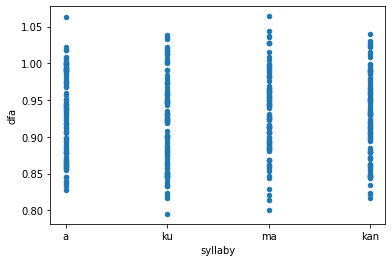

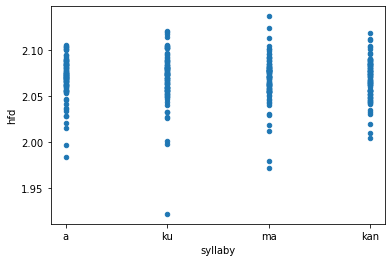

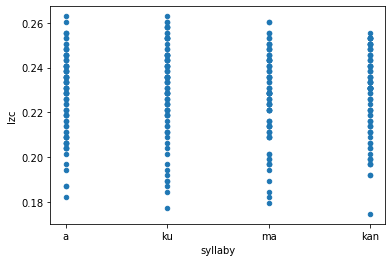

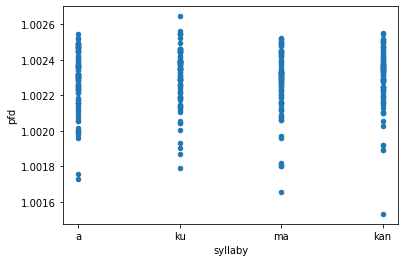

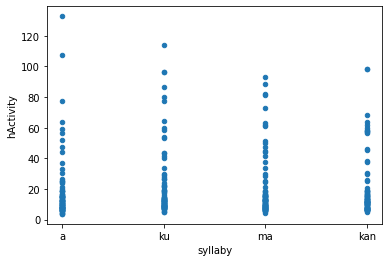

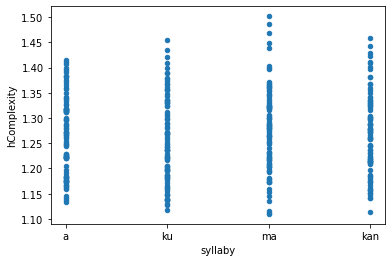

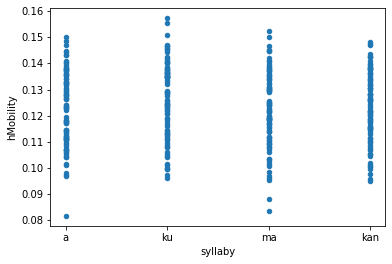

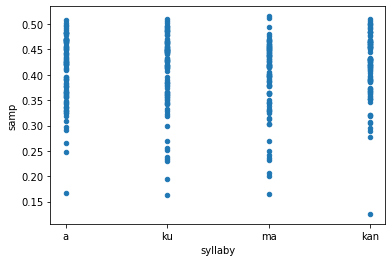

In [ ]:
data_fitur = pd.read_csv('/content/drive/MyDrive/PKM_KC_EEG_2021/Hasil_Feature_Visualisasi_4.csv',\
                         names = ['dfa', 'hfd', 'lzc', 'pfd','hActivity',\
                          'hComplexity', 'hMobility', 'samp','syllaby'], skiprows=1)
ax1 = data_fitur.plot.scatter(x = 'syllaby', y = 'dfa')
ax2 = data_fitur.plot.scatter(x = 'syllaby', y = 'hfd')
ax3 = data_fitur.plot.scatter(x = 'syllaby', y = 'lzc')
ax4 = data_fitur.plot.scatter(x = 'syllaby', y = 'pfd')
ax5 = data_fitur.plot.scatter(x = 'syllaby', y = 'hActivity')
ax6 = data_fitur.plot.scatter(x = 'syllaby', y = 'hComplexity')
ax7 = data_fitur.plot.scatter(x = 'syllaby', y = 'hMobility')
ax8 = data_fitur.plot.scatter(x = 'syllaby', y = 'samp')

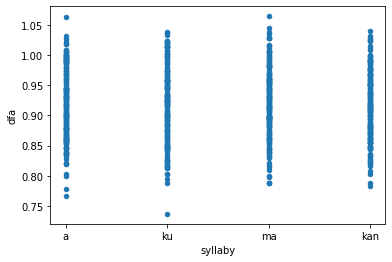

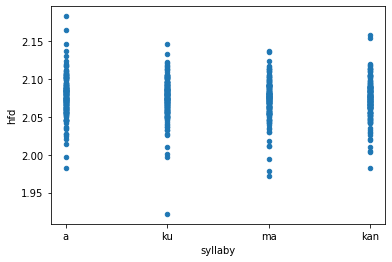

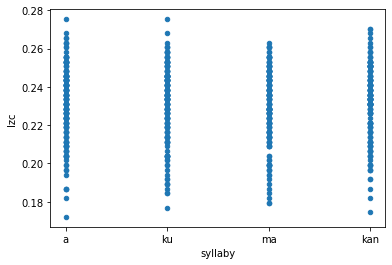

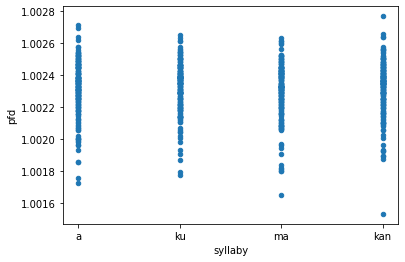

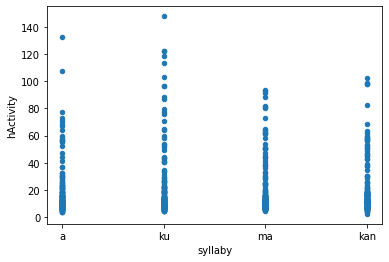

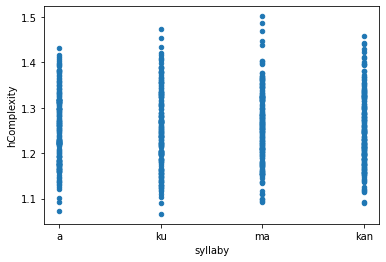

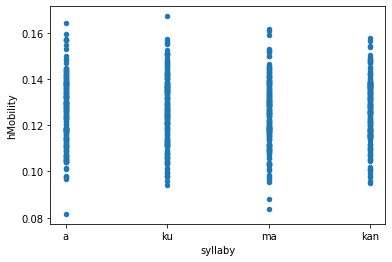

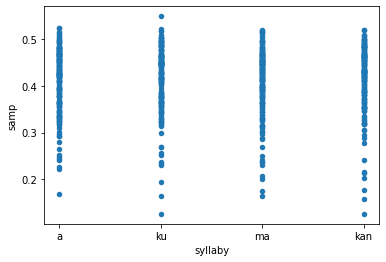

In [ ]:
data_fitur = pd.read_csv('/content/drive/MyDrive/PKM_KC_EEG_2021/Hasil_Feature_Semua_4.csv',\
                         names = ['mode', 'dfa', 'hfd', 'lzc', 'pfd','hActivity',\
                          'hComplexity', 'hMobility', 'samp','syllaby'], skiprows=1)
ax1 = data_fitur.plot.scatter(x = 'syllaby', y = 'dfa')
ax2 = data_fitur.plot.scatter(x = 'syllaby', y = 'hfd')
ax3 = data_fitur.plot.scatter(x = 'syllaby', y = 'lzc')
ax4 = data_fitur.plot.scatter(x = 'syllaby', y = 'pfd')
ax5 = data_fitur.plot.scatter(x = 'syllaby', y = 'hActivity')
ax6 = data_fitur.plot.scatter(x = 'syllaby', y = 'hComplexity')
ax7 = data_fitur.plot.scatter(x = 'syllaby', y = 'hMobility')
ax8 = data_fitur.plot.scatter(x = 'syllaby', y = 'samp')

# DeepLearning Klasifikasi EEG 

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install tensorflow==2.5.0

     |████████████████████████████████| 454.3 MB 14 kB/s 
     |████████████████████████████████| 1.2 MB 44.9 MB/s 
     |████████████████████████████████| 462 kB 66.5 MB/s 
     |████████████████████████████████| 4.0 MB 60.0 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.40.0
    Uninstalling grpcio-1.40.0:
      Successfully uninstalled grpcio-1.40.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.0:
      Successfully uninstalled tensorflow-2.6.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import pathlib

In [ ]:
print(tf.__version__)

2.5.0


In [ ]:
# Ubah file yang mau dicari hasilnya

data_fitur = pd.read_csv('/content/drive/MyDrive/PKM_KC_EEG_2021/Hasil Fitur Ekstraksi/Hasil_Feature_Visualisasi_2.csv',\
                         names = ['dfa', 'hfd', 'lzc', 'pfd','hActivity',\
                          'hComplexity', 'hMobility', 'samp','syllaby'], skiprows=1)

data_fitur_input = data_fitur.copy()
data_fitur_output = data_fitur_input.pop('syllaby')

labelencoder_y = LabelEncoder()
y_ = labelencoder_y.fit_transform(data_fitur_output)

y = to_categorical(y_)

In [ ]:
# Ubah file yang mau dicari hasilnya

data_fitur = pd.read_csv('/content/drive/MyDrive/PKM_KC_EEG_2021/Hasil_Feature_Visualisasi_std_3.csv',\
                         names = ['Coef Aprox', 'Coef Detail 9', 'Coef Detail 8',\
                              'Coef Detail 7', 'Coef Detail 6', 'Coef Detail 5', 'Coef Detail 4',\
                              'Coef Detail 3' , 'Coef Detail 2', 'Coef Detail 1', 'syllaby'], skiprows=1)
data_fitur_input = data_fitur.copy()
data_fitur_output = data_fitur_input.pop('syllaby')

labelencoder_y = LabelEncoder()
y_ = labelencoder_y.fit_transform(data_fitur_output)

y = to_categorical(y_)

In [ ]:
print(y_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
data_fitur.head(50)

dfa       hfd       lzc  ...  hMobility      samp  syllaby
0   0.885379  2.103405  0.233508  ...   0.131902  0.438142        a
1   0.969737  2.079863  0.204012  ...   0.110634  0.376388        a
2   0.935607  2.105502  0.233508  ...   0.118395  0.427103        a
3   1.008026  2.033639  0.204012  ...   0.098054  0.355456        a
4   0.978525  2.088554  0.226134  ...   0.110738  0.369983        a
5   1.021756  2.069938  0.211386  ...   0.097399  0.331066        a
6   1.017546  2.103180  0.201554  ...   0.096899  0.308991        a
7   0.943808  2.046432  0.235966  ...   0.117829  0.442648        a
8   1.007405  2.046005  0.181890  ...   0.111875  0.167710        a
9   0.999818  2.094102  0.196638  ...   0.106738  0.365432        a
10  0.985816  2.076908  0.208928  ...   0.104025  0.344156        a
11  0.928601  2.092137  0.204012  ...   0.122971  0.297656        a
12  1.001993  2.041667  0.186806  ...   0.105577  0.328037        a
13  0.911721  2.081024  0.235966  ...   0.128145  0.454927        a
14  1.062775  1.996806  0.186806  ...   0.081637  0.291958        a
15  0.931240  2.064498  0.211386  ...   0.125803  0.359573       ku
16  1.022747  2.032942  0.204012  ...   0.096058  0.344782       ku
17  0.956744  2.067664  0.226134  ...   0.114667  0.424643       ku
18  0.950666  2.060193  0.223676  ...   0.122287  0.418897       ku
19  1.012965  2.054954  0.176974  ...   0.099523  0.366159       ku
20  0.973321  2.081833  0.216302  ...   0.111372  0.355312       ku
21  1.020216  2.001139  0.194180  ...   0.108118  0.194228       ku
22  0.922811  2.083850  0.235966  ...   0.124891  0.448513       ku
23  0.973716  2.056489  0.184348  ...   0.116796  0.234594       ku
24  1.007063  2.064891  0.196638  ...   0.101575  0.377465       ku
25  1.033290  2.058403  0.189264  ...   0.100981  0.230426       ku
26  0.946098  2.078080  0.231050  ...   0.118024  0.444186       ku
27  0.945714  2.049003  0.235966  ...   0.120917  0.388892       ku
28  0.863785  2.094540  0.233508  ...   0.134752  0.487249       ku
29  1.038826  2.051839  0.186806  ...   0.097431  0.252450       ku
30  0.925680  2.123975  0.208928  ...   0.123987  0.200331       ma
31  0.981107  2.088182  0.213844  ...   0.111582  0.363547       ma
32  0.983892  2.055309  0.194180  ...   0.115272  0.206515       ma
33  1.027654  2.095827  0.179432  ...   0.098502  0.164878       ma
34  0.948946  2.077948  0.231050  ...   0.118231  0.414523       ma
35  0.999323  2.030313  0.196638  ...   0.107054  0.312194       ma
36  1.027580  2.070908  0.181890  ...   0.097016  0.302096       ma
37  0.995265  1.978914  0.196638  ...   0.101625  0.241253       ma
38  0.966783  2.068363  0.208928  ...   0.110837  0.415744       ma
39  0.949965  2.080635  0.228592  ...   0.116571  0.438592       ma
40  1.044601  2.113212  0.196638  ...   0.087934  0.268607       ma
41  0.943195  2.079770  0.228592  ...   0.116874  0.438602       ma
42  0.906307  2.090929  0.223676  ...   0.129755  0.424921       ma
43  0.913319  2.098590  0.233508  ...   0.118339  0.455902       ma
44  0.989274  2.073282  0.211386  ...   0.111648  0.398502       ma
45  0.898371  2.052263  0.216302  ...   0.130542  0.318376      kan
46  1.012111  2.061325  0.196638  ...   0.100508  0.372443      kan
47  0.954534  2.090297  0.231050  ...   0.114997  0.392135      kan
48  0.968804  2.004832  0.174516  ...   0.121843  0.125833      kan
49  0.984859  2.055637  0.213844  ...   0.109732  0.387336      kan

[50 rows x 9 columns]

In [ ]:
nilai = y[0]
print(nilai)
for element in y:
  if str(element) != str(nilai):
    print(element)
    nilai = element

[1. 0. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]
[0. 1. 0. 0.]
[1. 0. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]
[0. 1. 0. 0.]
[1. 0. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]
[0. 1. 0. 0.]
[1. 0. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]
[0. 1. 0. 0.]
[1. 0. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]
[0. 1. 0. 0.]
[1. 0. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]
[0. 1. 0. 0.]


In [ ]:
data_fitur_input

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_fitur_input, y, test_size=0.2)

# print(x_train)
# print(type(x_train))

x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

print(y_train)
print(y_train.shape)


tf.Tensor(
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]], shape=(288, 4), dtype=float32)
(288, 4)


In [ ]:
model_ANN = tf.keras.models.Sequential([
  keras.layers.Dense(units=256, activation="relu", input_shape=[8]),
  keras.layers.Dense(units=128, activation="relu"),
  keras.layers.Dense(units=128, activation="relu"),
  keras.layers.Dense(units=64, activation="relu"),
  keras.layers.Dense(units=64, activation="relu"),
  keras.layers.Dense(units=32, activation="relu"),
  keras.layers.Dense(units=32, activation="relu"),
  keras.layers.Dense(units=16, activation="relu"),
  keras.layers.Dense(units=16, activation="relu"),
  keras.layers.Dense(units=4, activation='softmax')
])
adam = Adam(lr=0.09)
model_ANN.compile(loss='CategoricalCrossentropy', optimizer=adam, metrics=['accuracy'])

model_ANN.summary()

history = model_ANN.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test))

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = [0.9015256198223797, 2.0871126246133604, 0.23842370668799795, 1.002377214912375, 9.526773994561083, 1.2384427350889338, 0.12746585506355132, 0.44067598502741284]
score = np.array([score])
y_score = model_ANN.predict_classes(score)
print(y_score)
if y_score == np.array([0]):
  hasil = 'a'
elif y_score == np.array([2]):
  hasil = 'ku'
elif y_score == np.array([3]):
  hasil = 'ma'
elif y_score == np.array([1]):
  hasil = 'kan'

print(hasil)

[2]
ku


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
model_ANN.save('/content/model_ANN.h5')

In [ ]:
path = '/content/drive/MyDrive/PKM_KC_EEG_2021'
feature = ['dfa', 'hfd', 'lzc', 'pfd', 'hActivity', 'hComplexity',\
           'hMobility', 'samp', 'syllaby']
mode = ['visualisasi', 'gabungan']
dict_features_hasil = {}

for element in feature:
  for cara in mode:
    dict_features_hasil['{}_{}'.format(element, cara)] = []

print(dict_features_hasil)

with open(os.path.join(path, 'Hasil_Feature_Semua.csv')) as reader:
  data_reader = csv.reader(reader, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
  line_count = 0
  for row in data_reader:
    if line_count == 0:
      line_count += 1
    else:
      for element in feature:
        if row[0] == 'visualisasi':
          dict_features_hasil['{}_visualisasi'.format(element)].append(row[feature.index(element)+1])
        dict_features_hasil['{}_gabungan'.format(element)].append(row[feature.index(element)+1])

In [ ]:
split = int(0.8*len(dict_features_hasil['syllaby_visualisasi']))
dict_train = {}
dict_test = {}

for keys in dict_features_hasil:
  dict_train[keys] = dict_features_hasil[keys][:split]
  dict_test[keys] = dict_features_hasil[keys][split:]

print(len(dict_train['dfa_visualisasi']))
print(len(dict_test['dfa_visualisasi']))

In [ ]:
x_train_visualisasi = []
y_train_visualisasi = []
x_test_visualisasi = []
y_test_visualisasi = []
x_train_gabungan = []
y_train_gabungan = []
x_test_gabungan = []
y_test_gabungan = []

for i in range(len(dict_train['dfa_visualisasi'])):
  list_visualisasi = []
  for element in feature:
    if element != 'syllaby':
      list_visualisasi.append(float(dict_train['{}_visualisasi'.format(element)][i]))
    else:
      y_train_visualisasi.append(dict_train['{}_visualisasi'.format(element)][i])
  x_train_visualisasi.append(list_visualisasi)

for i in range(len(dict_test['dfa_visualisasi'])):
  list_visualisasi = []
  for element in feature:
    if element != 'syllaby':
      list_visualisasi.append(float(dict_test['{}_visualisasi'.format(element)][i]))
    else:
      y_test_visualisasi.append(dict_test['{}_visualisasi'.format(element)][i])
  x_test_visualisasi.append(list_visualisasi)

for i in range(len(dict_train['dfa_gabungan'])):
  list_gabungan = []
  for element in feature:
    if element != 'syllaby':
      list_gabungan.append(float(dict_train['{}_gabungan'.format(element)][i]))
    else:
      y_train_gabungan.append(dict_train['{}_gabungan'.format(element)][i])
  x_train_gabungan.append(list_gabungan)

for i in range(len(dict_test['dfa_gabungan'])):
  list_gabungan = []
  for element in feature:
    if element != 'syllaby':
      list_gabungan.append(float(dict_test['{}_gabungan'.format(element)][i]))
    else:
      y_test_gabungan.append(dict_test['{}_gabungan'.format(element)][i])
  x_test_gabungan.append(list_gabungan)

x_train_visualisasi = np.array(x_train_visualisasi)
y_train_visualisasi = np.array(y_train_visualisasi)
x_test_visualisasi = np.array(x_test_visualisasi)
y_test_visualisasi = np.array(y_test_visualisasi)
x_train_gabungan = np.array(x_train_gabungan)
y_train_gabungan = np.array(y_train_gabungan) 
x_test_gabungan = np.array(x_test_gabungan)
y_test_gabungan = np.array(y_test_gabungan)

In [ ]:
print(len(y_train_visualisasi))
print(type(y_train_visualisasi))
print(y_train_visualisasi.shape)
print(x_train_visualisasi.shape)

In [ ]:
sample = data.loc[0, 'fft_0_b':'fft_749_b']

plt.figure(figsize=(16, 10))
plt.plot(range(len(sample)), sample)
plt.title("Features fft_0_b through fft_749_b")
plt.show()

In [ ]:
data['label'].value_counts()

In [ ]:
label_mapping = {'a':0, 'ku':1, 'ki':2, 'ta':3, 'ma':4, 'in':4, 'kan':5, 'bo':6, 'la':7, 'yam':8}

In [ ]:
def preprocess_inputs(df):
    df = df.copy()
    
    df['label'] = df['label'].replace(label_mapping)
    
    y = df['label'].copy()
    X = df.drop('label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [ ]:
X_train


In [ ]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)

gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

In [ ]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

In [ ]:
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

# Program ekstraksi fitur zenodo

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Ekstraksi fitur dengan cara Scott Wellington; Jonathan Clayton

In [ ]:
!wget https://zenodo.org/record/3554128/files/scottwellington/FEIS-v1.1.zip /content/

--2021-08-30 20:30:04--  https://zenodo.org/record/3554128/files/scottwellington/FEIS-v1.1.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647825020 (1.5G) [application/octet-stream]
Saving to: ‘FEIS-v1.1.zip.1’

FEIS-v1.1.zip.1     100%[===================>]   1.53G  9.75MB/s    in 3m 46s  

2021-08-30 20:33:52 (6.95 MB/s) - ‘FEIS-v1.1.zip.1’ saved [1647825020/1647825020]

/content/: Scheme missing.
FINISHED --2021-08-30 20:33:52--
Total wall clock time: 3m 48s
Downloaded: 1 files, 1.5G in 3m 46s (6.95 MB/s)


In [ ]:
from zipfile import ZipFile

In [ ]:
with ZipFile('/content/FEIS-v1.1.zip', 'r') as zip:
    zip.printdir()
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
scottwellington-FEIS-7e726fd/                  2019-10-08 07:40:28            0
scottwellington-FEIS-7e726fd/B059691/          2019-10-08 07:40:28            0
scottwellington-FEIS-7e726fd/B059691/code/     2019-10-08 07:40:28            0
scottwellington-FEIS-7e726fd/B059691/code/Deep4Net.py 2019-10-08 07:40:28        14664
scottwellington-FEIS-7e726fd/B059691/code/VCTK_downsample.py 2019-10-08 07:40:28          656
scottwellington-FEIS-7e726fd/B059691/code/autoencoder.py 2019-10-08 07:40:28        12152
scottwellington-FEIS-7e726fd/B059691/code/average_trials.py 2019-10-08 07:40:28         4734
scottwellington-FEIS-7e726fd/B059691/code/batch_kara_data.py 2019-10-08 07:40:28         7958
scottwellington-FEIS-7e726fd/B059691/code/csv2wav.py 2019-10-08 07:40:28         5318
scottwellington-FEIS-7e726fd/B059691/code/experiment_randomiser_(for_trials).py 2019-10-08 07:40:28         4513
scottwellington-FEIS-7e

In [ ]:
# Program Deeplearning Deep4Net
%pycat /content/scottwellington-FEIS-7e726fd/B059691/code/Deep4Net.py

In [ ]:
# Program Downsampling
%pycat /content/scottwellington-FEIS-7e726fd/B059691/code/VCTK_downsample.py

In [ ]:
# Program Deeplearning dengan bottleneck features
%pycat /content/scottwellington-FEIS-7e726fd/B059691/code/autoencoder.py

In [ ]:
# Program Penyiapan Data
%pycat /content/scottwellington-FEIS-7e726fd/B059691/code/average_trials.py

In [ ]:
# Program Mencari Fitr Box-Cox, Min Max, dan MVN
%pycat /content/scottwellington-FEIS-7e726fd/B059691/code/features2norm.py

# Program Ekstraksi Fitur Skripsi Kating

Skripsi La Febry Andira Rose Cynthia

# Program Text to Speech

In [ ]:
!pip install gTTS

In [ ]:
from gtts import gTTS
from IPython.display import Audio
tts=gTTS('ku')
tts.save('1.wav')
sound_file= '1.wav'
Audio(sound_file, autoplay= True)

# Program bLSTM

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# !pip install tensorflow==2.5.0

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
from tensorflow.keras.models import load_model
import numpy as np 

In [ ]:
print(tf.__version__)
print(np.__version__)

2.5.0
1.19.5


In [ ]:
tokenizer = Tokenizer()

data = open('/content/drive/MyDrive/PKM_KC_EEG_2021/Prediksi.TXT').read()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'ma': 1, 'la': 2, 'a': 3, 'ki': 4, 'ta': 5, 'ku': 6, 'in': 7, 'kan': 8, 'bo': 9, 'yam': 10}
11


In [ ]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = ku.to_categorical(labels, num_classes=total_words)

In [ ]:
print(max_sequence_len-1)
print(total_words)

5
11


In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.09)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=100, verbose=1)
#print model.summary()
print(model)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5, 100)            1100      
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               301200    
_________________________________________________________________
dense_40 (Dense)             (None, 11)                3311      
Total params: 305,611
Trainable params: 305,611
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

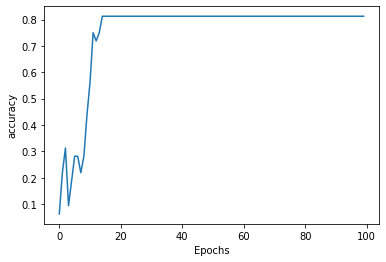

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
seed_text = "a"
next_words = 1

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	print(token_list)
	print(type(token_list))
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	print(token_list)
	print(type(token_list))
	print(token_list.shape)
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

In [ ]:
model.save('/content/model_RNN.h5')

In [ ]:
from tensorflow.keras.models import load_model

def prediksiRNN(seed_text, next_words = 1):
  model = load_model('/content/drive/MyDrive/PKM_KC_EEG_2021/model/model_RNN.h5')
  tokenizer = Tokenizer()
  data = open('/content/drive/MyDrive/PKM_KC_EEG_2021/Prediksi.TXT').read()
  corpus = data.lower().split("\n")
  tokenizer.fit_on_texts(corpus)
  total_words = len(tokenizer.word_index) + 1
  input_sequences = []
  for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
      n_gram_sequence = token_list[:i+1]
      input_sequences.append(n_gram_sequence)
  # pad sequences 
  max_sequence_len = max([len(x) for x in input_sequences])
  input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    seed_text += " " + output_word
  print(seed_text)
  return seed_text

In [ ]:
hasil = prediksiRNN('a')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


a ku


# Coba-coba
(Abaikan saja)

In [ ]:
# !git clone https://github.com/Cly1st/ECG-Arrhythmia-Classification-using-Artificial-Neural-Network.git

In [ ]:
!cat /content/drive/MyDrive/ECG-Arrhythmia-Classification-using-Artificial-Neural-Network-master/Training.py

In [ ]:
!cat /content/drive/MyDrive/ECG-Arrhythmia-Classification-using-Artificial-Neural-Network-master/Test.py

In [ ]:
!cat /content/drive/MyDrive/PKM_KC_EEG_2021/revolution-python-api-master/bitalino.py

In [ ]:
# Module to install
import platform
import math
import numpy
import re
import socket
import serial
import struct
import time
import select
import sys
import h5py
import scipy.signal as signal
import pywt
import h5py
import wrcoef
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from statistics import mean, median, mode, stdev
import csv
import h5py
import pywt
import eeglib
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
from tensorflow.keras.models import load_model
from tensorflow import keras
from gtts import gTTS
from IPython.display import Audio